This notebook relates to Figure 3 and Figure 6 of the APNet manuscript visualising and calculating AUC scores, F1 scores with corresponding SHAP values from the various APNet/benchmark model deployments in various scenarios.

# Dependencies

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
root_dir = "/content/drive/My Drive/"
project_folder = "APNet_input_data"
os.chdir(root_dir + project_folder)
!pwd

Mounted at /content/drive
/content/drive/My Drive/APNet_input_data


We are depicting the metrics from the neural network outputs during classification of Severe COVID-19 cases from activity based experiments (MGH-Mayo, MGH-Stanford, MGH-scMGH)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
import matplotlib.image as mpimg
from scipy.stats import t

# APNet_deployment - Figure 3

We will plot the AUC scores from APNet deployment in the various scenarios: , APNet_Stanford: MGH(training) -

*   APNet_Mayo: MGH(training) - Mayo(testing)
*   APNet_Stanford: MGH(training) - Stanford(testing)
*   APNet_scMGH: bulk proteomic MGH(training) - single-cell MGH(testing)

## APNet graphical abstract

In [ ]:
# Load the image
image_path_A = 'APNet_gr_abstr.png'
img_A = mpimg.imread(image_path_A)

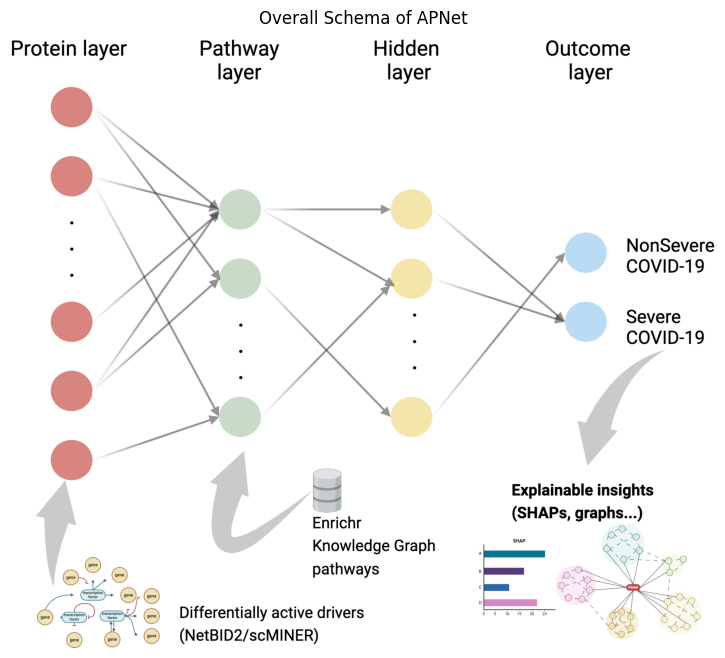

In [ ]:
# Create a figure
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the image
ax.imshow(img_A)
ax.axis('off')
ax.set_title('Overall Schema of APNet')

plt.show()

## AUC scores

In [ ]:
# Load data
dc_mayo_ac = pd.read_excel('MGH_Mayo_experiment/Deep_Learning_inputs/MAYO_TEST.xlsx')
fl_mayo_ac = pd.read_csv('MGH_Mayo_experiment/Deep_Learning_outputs/PASNet_pred_0_0.txt', sep=',', names=['first', 'second'])

dc_stanford_ac = pd.read_excel('MGH_Stanford_experiment/Deep_Learning_inputs/STANFORD_TEST.xlsx')
fl_stanford_ac = pd.read_csv('MGH_Stanford_experiment/Deep_Learning_outputs/PASNet_pred_0_0.txt', sep=',', names=['first', 'second'])

dc_scmgh_ac = pd.read_excel('MGH_scMGH_experiment/Deep_Learning_inputs/scMGH_TEST.xlsx')
fl_scmgh_ac = pd.read_csv('MGH_scMGH_experiment/Deep_Learning_outputs/PASNet_pred_0_0.txt', sep=',', names=['first', 'second'])

In [ ]:
# Combine predictions
fl_mayo_ac['combined'] = fl_mayo_ac.values.tolist()
fl_stanford_ac['combined'] = fl_stanford_ac.values.tolist()
fl_scmgh_ac['combined'] = fl_scmgh_ac.values.tolist()

y_pred_mayo_ac = np.array(list(fl_mayo_ac.combined))
y_pred_stanford_ac = np.array(list(fl_stanford_ac.combined))
y_pred_scmgh_ac = np.array(list(fl_scmgh_ac.combined))

def vectorized_label(target, n_class):
    TARGET = np.array(target).reshape(-1)
    return np.eye(n_class)[TARGET]

y_mayo_ac = dc_mayo_ac['Condition'].astype(int)
y_true_mayo_ac = vectorized_label(y_mayo_ac, 2)

y_stanford_ac = dc_stanford_ac['Condition'].astype(int)
y_true_stanford_ac = vectorized_label(y_stanford_ac, 2)

y_scmgh_ac = dc_scmgh_ac['Condition'].astype(int)
y_true_scmgh_ac = vectorized_label(y_scmgh_ac, 2)

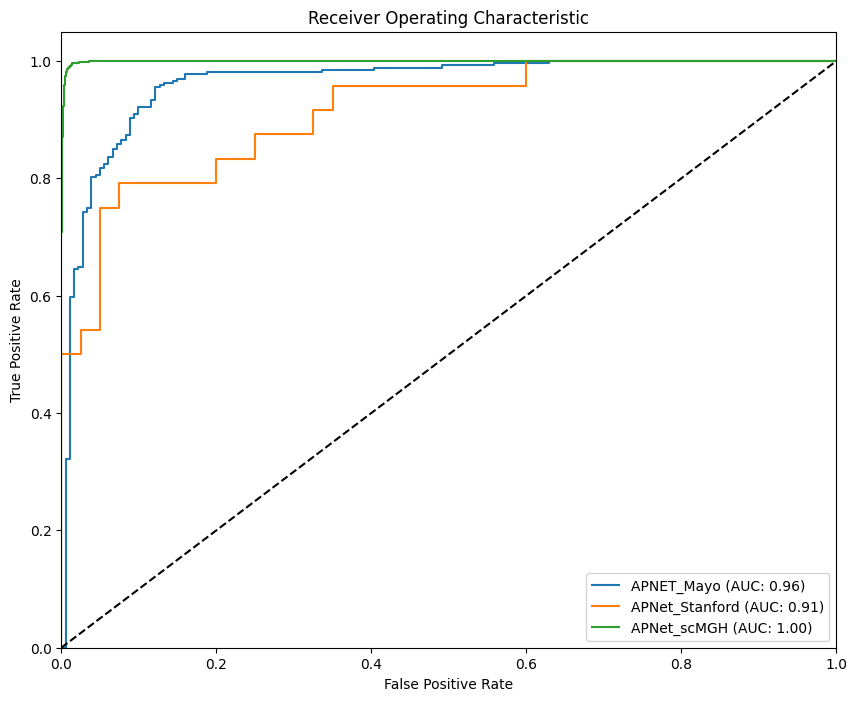

In [ ]:
# Calculate ROC curves and AUCs
experiments = [
    ('APNET_Mayo (AUC: {:.2f})', y_true_mayo_ac, y_pred_mayo_ac),
    ('APNet_Stanford (AUC: {:.2f})', y_true_stanford_ac, y_pred_stanford_ac),
    ('APNet_scMGH (AUC: {:.2f})', y_true_scmgh_ac, y_pred_scmgh_ac)
]

fig, ax = plt.subplots(figsize=(10, 8))

colors = []

for label, y_true, y_pred in experiments:
    if y_true.shape[0] != y_pred.shape[0]:
        min_length = min(y_true.shape[0], y_pred.shape[0])
        y_true = y_true[:min_length]
        y_pred = y_pred[:min_length]

    fpr, tpr, _ = roc_curve(y_true[:, 1], y_pred[:, 1])
    roc_auc = auc(fpr, tpr)
    line = ax.plot(fpr, tpr, label=label.format(roc_auc))
    colors.append(line[0].get_color())

# Plot settings for ROC curves
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver Operating Characteristic')
ax.legend(loc="lower right")

plt.show()

## F1 scores

In [ ]:
# Data for bar plot
data = {
    'Method': ['APNet_Mayo', 'APNet_Stanford', 'APNet_scMGH'],
    'F1_score': [0.9098, 0.6842, 0.975] # These values are calculated in APNet_v3 Colab while the PASNet neural network is running on activity values
}

df = pd.DataFrame(data)

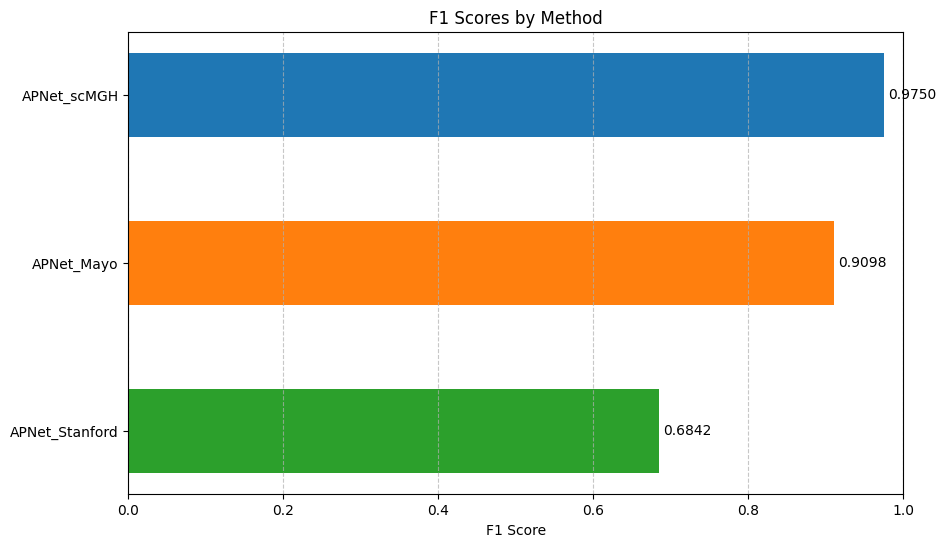

In [ ]:
# Sort the DataFrame by F1_score in descending order
df = df.sort_values(by='F1_score', ascending=False)

# Create the bar plot
fig, ax = plt.subplots(figsize=(10, 6))

bars = ax.barh(df['Method'], df['F1_score'], color=['#1f77b4', '#ff7f0e', '#2ca02c'], height=0.5)
ax.set_xlabel('F1 Score')
ax.set_title('F1 Scores by Method')
ax.set_xlim(0, 1)
ax.grid(axis='x', linestyle='--', alpha=0.7)
ax.invert_yaxis()  # Highest value on top

# Add text labels
for bar in bars:
    width = bar.get_width()
    ax.annotate(f'{width:.4f}', xy=(width, bar.get_y() + bar.get_height() / 2),
                xytext=(3, 0),  # 3 points horizontal offset
                textcoords="offset points",
                ha='left', va='center')

plt.show()

## SHAP values

In [ ]:
# Load the images
image_path_B = 'MGH_Mayo_experiment/Deep_Learning_outputs/shap_values20.png'
image_path_C = 'MGH_Stanford_experiment/Deep_Learning_outputs/shap_values20.png'
image_path_D = 'MGH_scMGH_experiment/Deep_Learning_outputs/shap_values20.png'

img_B = mpimg.imread(image_path_B)
img_C = mpimg.imread(image_path_C)
img_D = mpimg.imread(image_path_D)

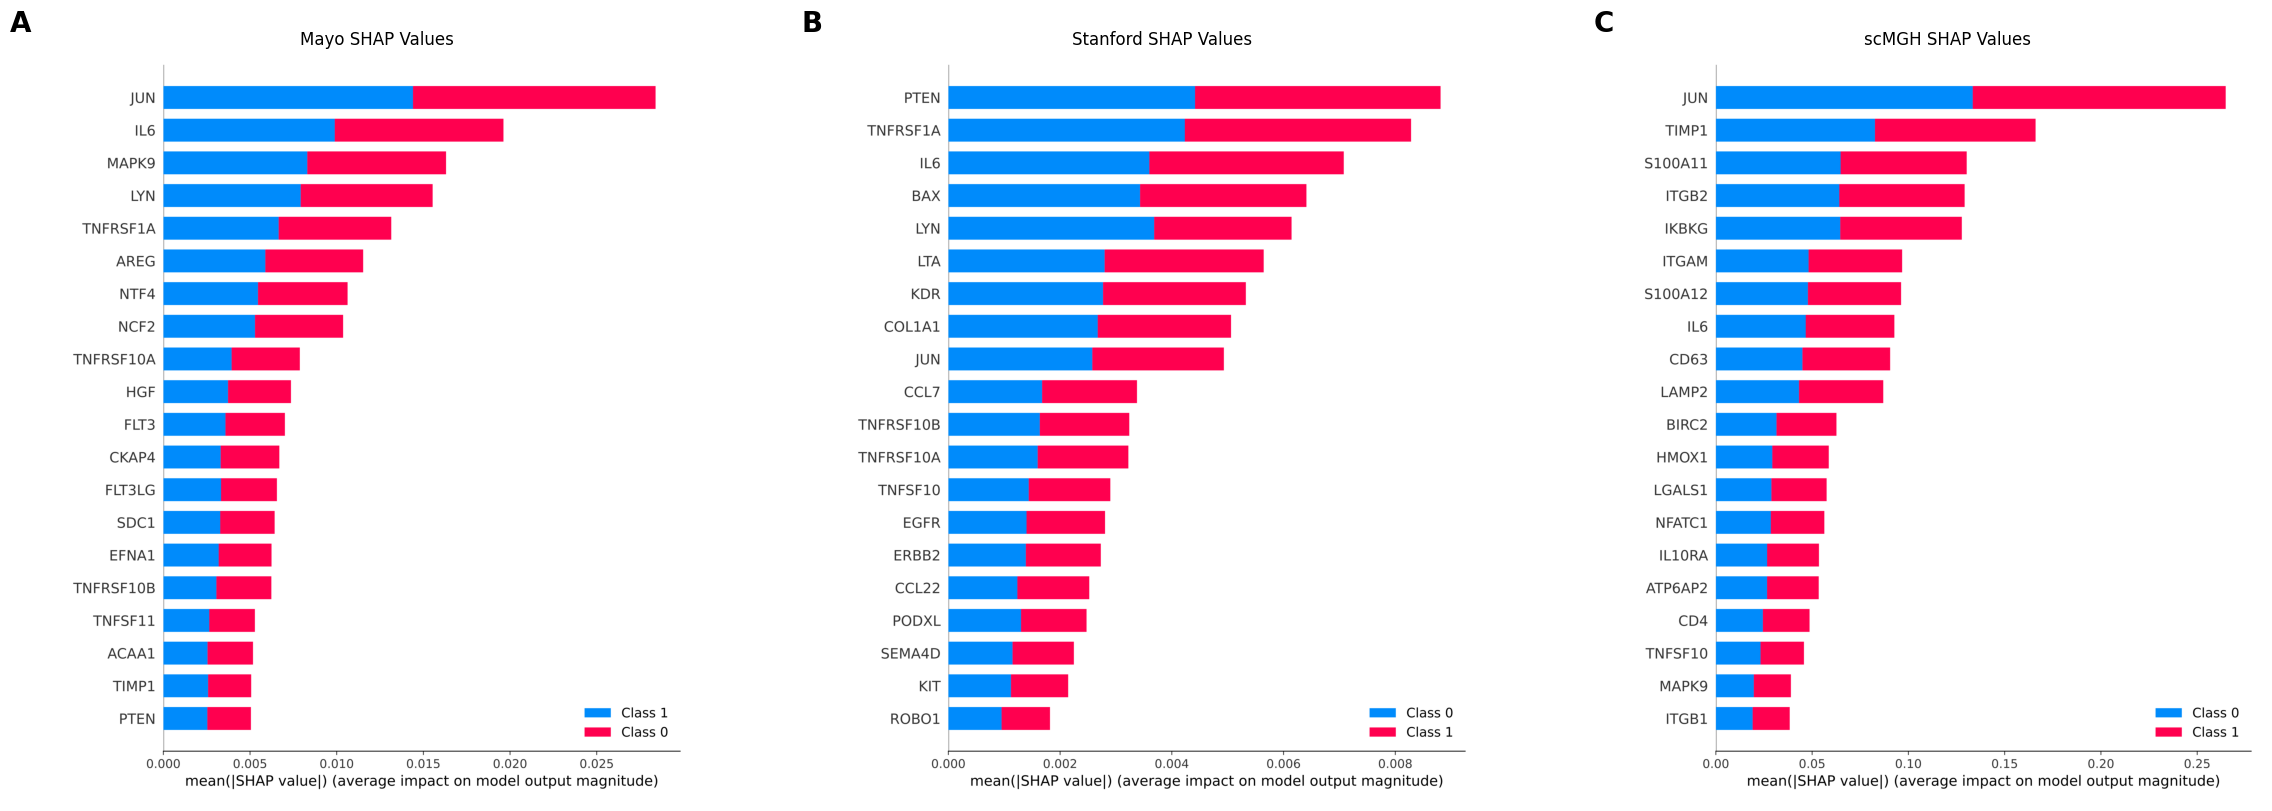

In [ ]:
# Create a figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(24, 8))

# Plot the images
axes[0].imshow(img_B)
axes[0].axis('off')
axes[0].set_title('Mayo SHAP Values')

axes[1].imshow(img_C)
axes[1].axis('off')
axes[1].set_title('Stanford SHAP Values')

axes[2].imshow(img_D)
axes[2].axis('off')
axes[2].set_title('scMGH SHAP Values')

# Add text labels
fig.text(0.02, 0.98, 'A', size=20, weight='bold', ha='left')
fig.text(0.35, 0.98, 'B', size=20, weight='bold', ha='left')
fig.text(0.68, 0.98, 'C', size=20, weight='bold', ha='left')

plt.tight_layout()
plt.show()

## t-statistic heatmaps

### MGH-Mayo

In [ ]:
# Load data for the first heatmap (MGH-Mayo)
df_mgh = pd.read_csv('MGH_Mayo_experiment/NetBID2_DA/DA_MGH.csv')
df_mayo = pd.read_csv('MGH_Mayo_experiment/NetBID2_DA/DA_Mayo.csv')
df_stanford = pd.read_csv('MGH_Stanford_experiment/NetBID2_DA/DA_Stanford.csv')
df_mgh_de = pd.read_csv('Benchmarking_studies/PASNet_Expression_Benchmark/MGH_Mayo_Benchmark/Results_DE/MGH_DE.csv')
df_mayo_de = pd.read_csv('Benchmarking_studies/PASNet_Expression_Benchmark/MGH_Mayo_Benchmark/Results_DE/Mayo_DE.csv')
df_stanford_de = pd.read_csv('Benchmarking_studies/PASNet_Expression_Benchmark/MGH_Stanford_Benchmark/Results_DE/Stanford_DE.csv')

In [ ]:
# List of top-20 SHAP values
proteins_of_interest_mayo = ["JUN", "IL6", "MAPK9", "LYN", "TNFRSF1A", "AREG",
                             "NTF4", "NCF2", "TNFRSF10A", "HGF", "FLT3", "CKAP4",
                             "FLT3LG", "SDC1", "EFNA1", "TNFRSF10B", "TNFSF11",
                             "ACAA1", "TIMP1", "PTEN"]

df_mgh_filtered = df_mgh[df_mgh['ID'].isin(proteins_of_interest_mayo)]
df_mayo_filtered = df_mayo[df_mayo['ID'].isin(proteins_of_interest_mayo)]
df_stanford_filtered = df_stanford[df_stanford['ID'].isin(proteins_of_interest_mayo)]
df_mgh_de_filtered = df_mgh_de[df_mgh_de['ID'].isin(proteins_of_interest_mayo)]
df_mayo_de_filtered = df_mayo_de[df_mayo_de['ID'].isin(proteins_of_interest_mayo)]
df_stanford_de_filtered = df_stanford_de[df_stanford_de['ID'].isin(proteins_of_interest_mayo)]

merged_df_t_full = df_mgh_filtered[['ID', 't']].merge(
    df_mayo_filtered[['ID', 't']], on='ID', suffixes=('_MGH_DA', '_Mayo_DA')).merge(
    df_stanford_filtered[['ID', 't']], on='ID', suffixes=('_Mayo_DA', '_Stanford_DA'))

merged_df_t_full = merged_df_t_full.rename(columns={'t': 't_Stanford_DA'})

merged_df_t_full = merged_df_t_full.merge(
    df_mgh_de_filtered[['ID', 't']], on='ID', suffixes=('', '_MGH_DE')).merge(
    df_mayo_de_filtered[['ID', 't']], on='ID', suffixes=('_MGH_DE', '_Mayo_DE')).merge(
    df_stanford_de_filtered[['ID', 't']], on='ID', suffixes=('_Mayo_DE', '_Stanford_DE'))

merged_df_t_full = merged_df_t_full.rename(columns={'t': 't_Stanford_DE'})
merged_df_t_full['mean_t'] = merged_df_t_full[['t_MGH_DA', 't_Mayo_DA', 't_Stanford_DA', 't_MGH_DE', 't_Mayo_DE', 't_Stanford_DE']].mean(axis=1)
merged_df_t_sorted_full = merged_df_t_full.sort_values(by='mean_t', ascending=False)
merged_df_t_sorted_full = merged_df_t_sorted_full.drop(columns=['mean_t'])
merged_df_t_sorted_full.set_index('ID', inplace=True)

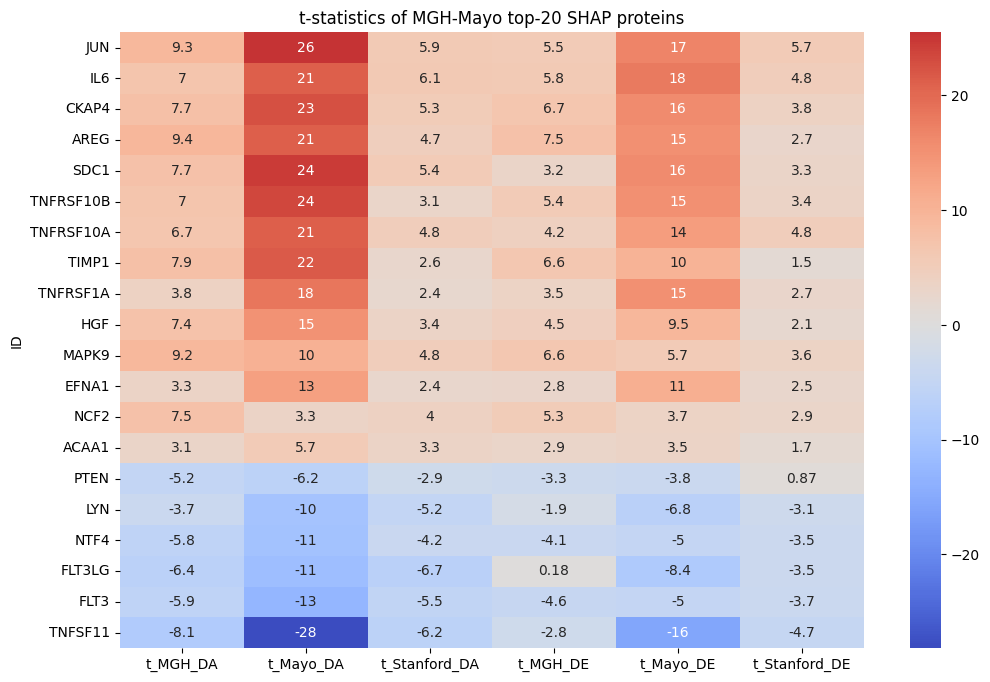

In [ ]:
# Create the heatmap
fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(merged_df_t_sorted_full, annot=True, cmap="coolwarm", center=0, ax=ax)
ax.set_title('t-statistics of MGH-Mayo top-20 SHAP proteins')

plt.show()

### MGH-Stanford

In [ ]:
# List of top-20 SHAP values
proteins_of_interest_stanford = ['PTEN', 'JUN', 'IL6', 'LYN', 'TNFRSF1A', 'TNFRSF10A', 'TNFRSF10B', 'TNFSF10',
                                 'BAX', 'LTA', 'KDR', 'COL1A1', 'CCL7', 'EGFR', 'ERBB2', 'CCL22', 'PODXL',
                                 'SEMA4D', 'KIT', 'ROBO1']

df_mgh_filtered = df_mgh[df_mgh['ID'].isin(proteins_of_interest_stanford)]
df_mayo_filtered = df_mayo[df_mayo['ID'].isin(proteins_of_interest_stanford)]
df_stanford_filtered = df_stanford[df_stanford['ID'].isin(proteins_of_interest_stanford)]
df_mgh_de_filtered = df_mgh_de[df_mgh_de['ID'].isin(proteins_of_interest_stanford)]
df_mayo_de_filtered = df_mayo_de[df_mayo_de['ID'].isin(proteins_of_interest_stanford)]
df_stanford_de_filtered = df_stanford_de[df_stanford_de['ID'].isin(proteins_of_interest_stanford)]

merged_df_t_full = df_mgh_filtered[['ID', 't']].merge(
    df_mayo_filtered[['ID', 't']], on='ID', suffixes=('_MGH_DA', '_Mayo_DA')).merge(
    df_stanford_filtered[['ID', 't']], on='ID', suffixes=('_Mayo_DA', '_Stanford_DA'))

merged_df_t_full = merged_df_t_full.rename(columns={'t': 't_Stanford_DA'})

merged_df_t_full = merged_df_t_full.merge(
    df_mgh_de_filtered[['ID', 't']], on='ID', suffixes=('', '_MGH_DE')).merge(
    df_mayo_de_filtered[['ID', 't']], on='ID', suffixes=('_MGH_DE', '_Mayo_DE')).merge(
    df_stanford_de_filtered[['ID', 't']], on='ID', suffixes=('_Mayo_DE', '_Stanford_DE'))

merged_df_t_full = merged_df_t_full.rename(columns={'t': 't_Stanford_DE'})
merged_df_t_full['mean_t'] = merged_df_t_full[['t_MGH_DA', 't_Mayo_DA', 't_Stanford_DA', 't_MGH_DE', 't_Mayo_DE', 't_Stanford_DE']].mean(axis=1)
merged_df_t_sorted_full = merged_df_t_full.sort_values(by='mean_t', ascending=False)
merged_df_t_sorted_full = merged_df_t_sorted_full.drop(columns=['mean_t'])
merged_df_t_sorted_full.set_index('ID', inplace=True)

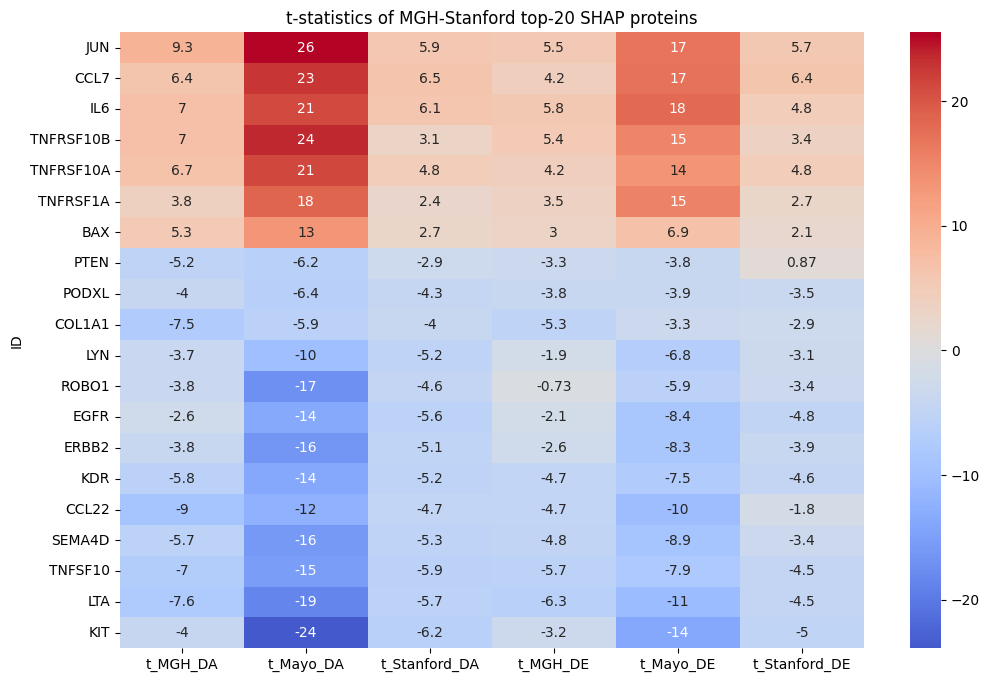

In [ ]:
# Create the heatmap
fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(merged_df_t_sorted_full, annot=True, cmap="coolwarm", center=0, ax=ax)
ax.set_title('t-statistics of MGH-Stanford top-20 SHAP proteins')

plt.show()

### bulk/scRNA-seq MGH

In [ ]:
# Load data for the third heatmap (MGH-scMGH)
file1_path = 'MGH_scMGH_experiment/NetBID2_scMINER_DA/DE_scMGH.csv'
file2_path = 'MGH_scMGH_experiment/NetBID2_scMINER_DA/DA_scMGH.csv'
file3_path = 'MGH_Mayo_experiment/NetBID2_DA/DA_MGH.csv'
file4_path = 'Benchmarking_studies/PASNet_Expression_Benchmark/MGH_Mayo_Benchmark/Results_DE/MGH_DE.csv'

df1 = pd.read_csv(file1_path)
df2 = pd.read_csv(file2_path)
df3 = pd.read_csv(file3_path)
df4 = pd.read_csv(file4_path)

In [ ]:
# Rename columns
df1 = df1.rename(columns={'id': 'ID', 't_Severe': 't'})
df2 = df2.rename(columns={'id': 'ID', 't_Severe': 't'})

# Remove the '.TF' suffix from the 'ID' column in df2
df2['ID'] = df2['ID'].str.replace('.TF', '', regex=False)
df1['ID'] = df1['ID'].str.replace('.TF', '', regex=False)

# List of top-20 SHAP values
proteins_of_interest = ['MAPK9', 'TIMP1', 'JUN', 'IL6', 'TNFSF10', 'S100A12', 'CD63', 'LAMP2',
                        'BIRC2', 'HMOX1', 'LGALS1', 'NFATC1', 'IL10RA', 'ATP6AP2', 'CD4', 'ITGB1']

# Filter dataframes for the proteins of interest
proteins_of_interest_set = set(proteins_of_interest)
df1_filtered = df1[df1['ID'].isin(proteins_of_interest_set)]
df2_filtered = df2[df2['ID'].isin(proteins_of_interest_set)]
df3_filtered = df3[df3['ID'].isin(proteins_of_interest_set)]
df4_filtered = df4[df4['ID'].isin(proteins_of_interest_set)]

# Merge the dataframes on the 'ID' column for t-statistics
merged_df_t = df1_filtered[['ID', 't']].merge(
    df2_filtered[['ID', 't']], on='ID', suffixes=('_DE_scMGH', '_DA_scMGH')).merge(
    df3_filtered[['ID', 't']], on='ID').merge(
    df4_filtered[['ID', 't']], on='ID', suffixes=('', '_MGH_DE'))

# Rename columns to ensure they are distinct
merged_df_t = merged_df_t.rename(columns={'t': 't_DA_MGH', 't_MGH_DE': 't_MGH_DE'})

# Calculate the mean t-statistic for ordering
merged_df_t['mean_t'] = merged_df_t[['t_DE_scMGH', 't_DA_scMGH', 't_DA_MGH', 't_MGH_DE']].mean(axis=1)

# Sort the dataframe by mean t-statistic in descending order
merged_df_t_sorted = merged_df_t.sort_values(by='mean_t', ascending=False)

# Drop the mean_t column
merged_df_t_sorted = merged_df_t_sorted.drop(columns=['mean_t'])

# Set the 'ID' column as index for the heatmap
merged_df_t_sorted.set_index('ID', inplace=True)

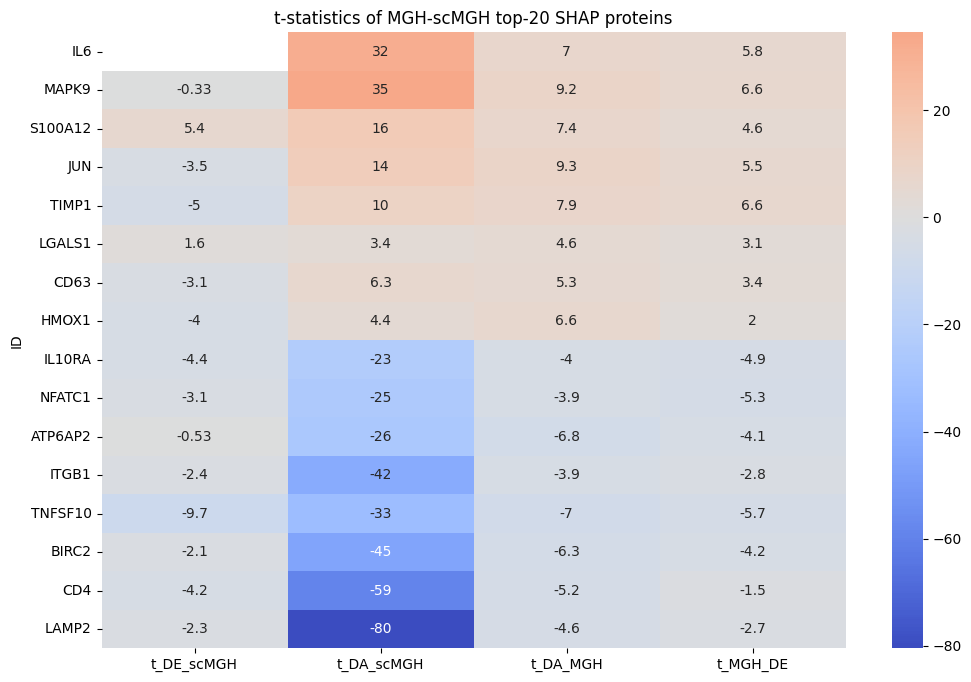

In [ ]:
# Create the heatmap
fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(merged_df_t_sorted, annot=True, cmap="coolwarm", center=0, ax=ax)
ax.set_title('t-statistics of MGH-scMGH top-20 SHAP proteins')

plt.show()

## Multipanel

This is to combine everything to a multi-panel figure

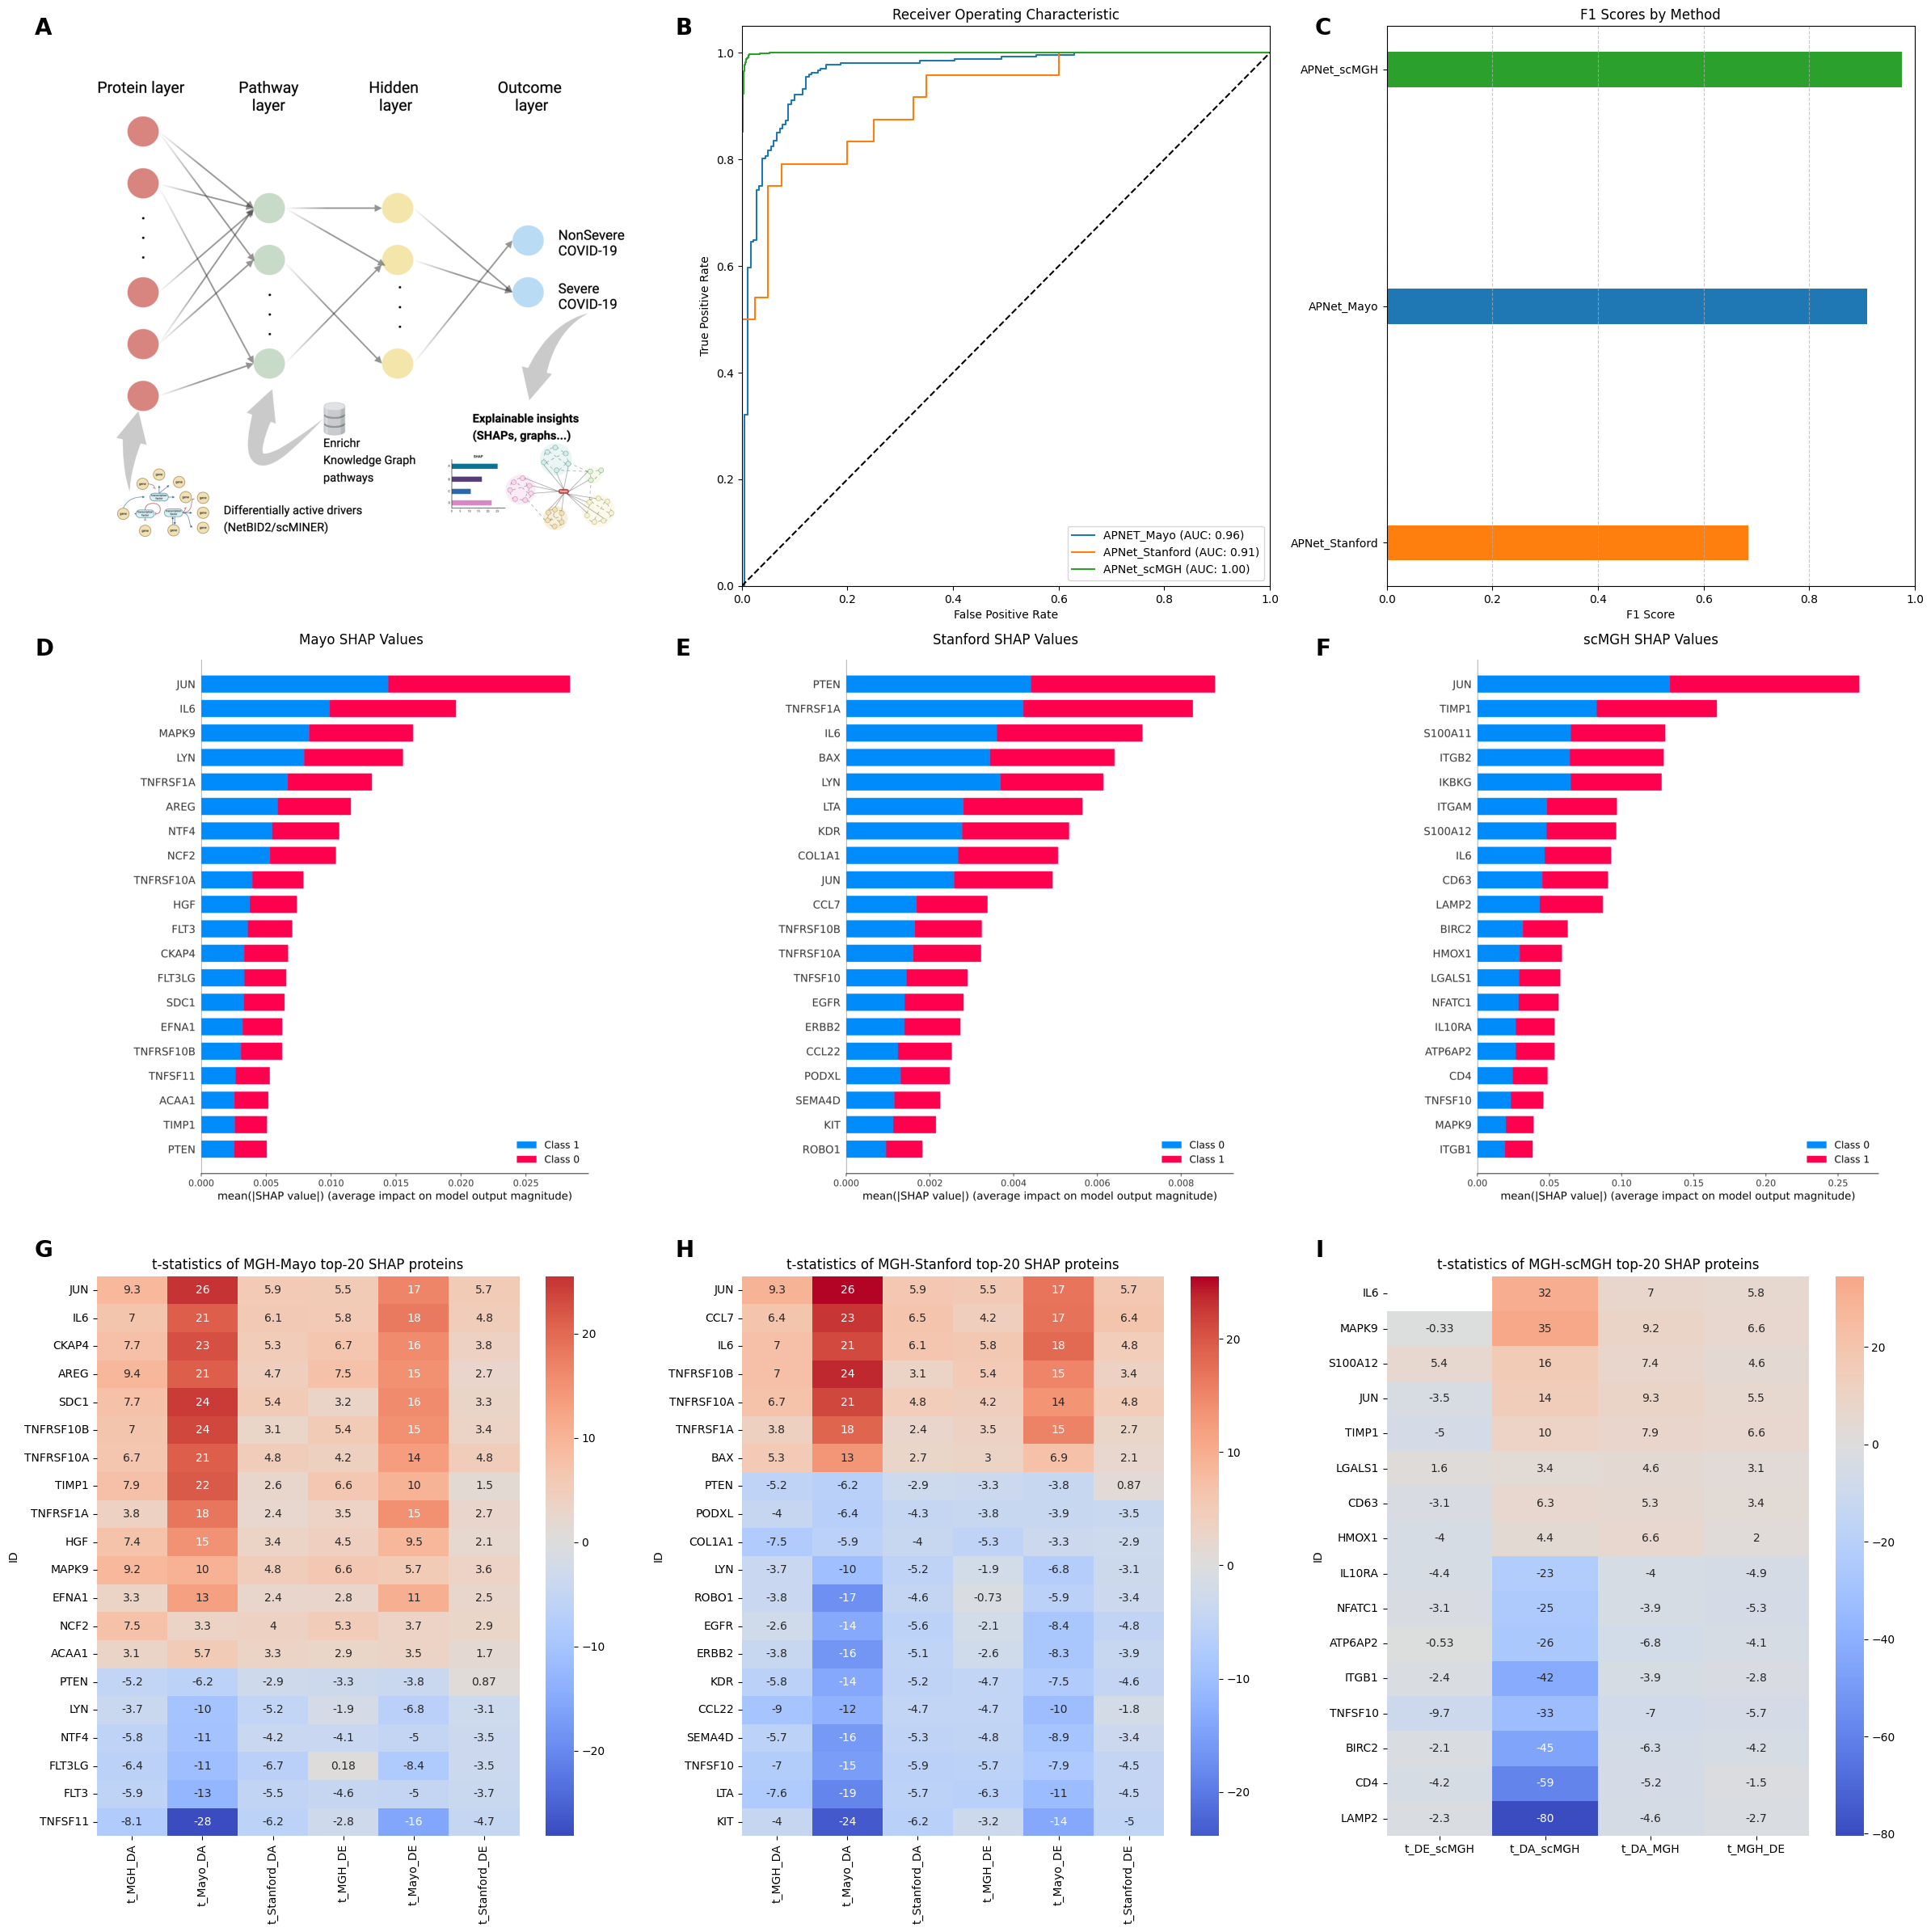

In [ ]:
# Load data
dc_mayo_ac = pd.read_excel('MGH_Mayo_experiment/Deep_Learning_inputs/MAYO_TEST.xlsx')
fl_mayo_ac = pd.read_csv('MGH_Mayo_experiment/Deep_Learning_outputs/PASNet_pred_0_0.txt', sep=',', names=['first', 'second'])

dc_stanford_ac = pd.read_excel('MGH_Stanford_experiment/Deep_Learning_inputs/STANFORD_TEST.xlsx')
fl_stanford_ac = pd.read_csv('MGH_Stanford_experiment/Deep_Learning_outputs/PASNet_pred_0_0.txt', sep=',', names=['first', 'second'])

dc_scmgh_ac = pd.read_excel('MGH_scMGH_experiment/Deep_Learning_inputs/scMGH_TEST.xlsx')
fl_scmgh_ac = pd.read_csv('MGH_scMGH_experiment/Deep_Learning_outputs/PASNet_pred_0_0.txt', sep=',', names=['first', 'second'])

# Combine predictions
fl_mayo_ac['combined'] = fl_mayo_ac.values.tolist()
fl_stanford_ac['combined'] = fl_stanford_ac.values.tolist()
fl_scmgh_ac['combined'] = fl_scmgh_ac.values.tolist()

y_pred_mayo_ac = np.array(list(fl_mayo_ac.combined))
y_pred_stanford_ac = np.array(list(fl_stanford_ac.combined))
y_pred_scmgh_ac = np.array(list(fl_scmgh_ac.combined))

def vectorized_label(target, n_class):
    TARGET = np.array(target).reshape(-1)
    return np.eye(n_class)[TARGET]

y_mayo_ac = dc_mayo_ac['Condition'].astype(int)
y_true_mayo_ac = vectorized_label(y_mayo_ac, 2)

y_stanford_ac = dc_stanford_ac['Condition'].astype(int)
y_true_stanford_ac = vectorized_label(y_stanford_ac, 2)

y_scmgh_ac = dc_scmgh_ac['Condition'].astype(int)
y_true_scmgh_ac = vectorized_label(y_scmgh_ac, 2)

# Calculate ROC curves and AUCs
experiments = [
    ('APNET_Mayo (AUC: {:.2f})', y_true_mayo_ac, y_pred_mayo_ac),
    ('APNet_Stanford (AUC: {:.2f})', y_true_stanford_ac, y_pred_stanford_ac),
    ('APNet_scMGH (AUC: {:.2f})', y_true_scmgh_ac, y_pred_scmgh_ac)
]

fig, axes = plt.subplots(3, 3, figsize=(24, 24))

# Load the images
image_path_A = 'APNet_gr_abstr.png'
image_path_B = 'MGH_Mayo_experiment/Deep_Learning_outputs/shap_values20.png'
image_path_C = 'MGH_Stanford_experiment/Deep_Learning_outputs/shap_values20.png'
image_path_D = 'MGH_scMGH_experiment/Deep_Learning_outputs/shap_values20.png'

img_A = mpimg.imread(image_path_A)
img_B = mpimg.imread(image_path_B)
img_C = mpimg.imread(image_path_C)
img_D = mpimg.imread(image_path_D)

# Plot the first image
axes[0, 0].imshow(img_A)
axes[0, 0].axis('off')

# Plot the second image
axes[1, 0].imshow(img_B)
axes[1, 0].axis('off')
axes[1, 0].set_title('Mayo SHAP Values')

# Plot the third image
axes[1, 1].imshow(img_C)
axes[1, 1].axis('off')
axes[1, 1].set_title('Stanford SHAP Values')

# Plot the fourth image
axes[1, 2].imshow(img_D)
axes[1, 2].axis('off')
axes[1, 2].set_title('scMGH SHAP Values')

# Plot ROC curves
colors = []

for label, y_true, y_pred in experiments:
    if y_true.shape[0] != y_pred.shape[0]:
        min_length = min(y_true.shape[0], y_pred.shape[0])
        y_true = y_true[:min_length]
        y_pred = y_pred[:min_length]

    fpr, tpr, _ = roc_curve(y_true[:, 1], y_pred[:, 1])
    roc_auc = auc(fpr, tpr)
    line = axes[0, 1].plot(fpr, tpr, label=label.format(roc_auc))
    colors.append(line[0].get_color())

# Plot settings for ROC curves
axes[0, 1].plot([0, 1], [0, 1], 'k--')
axes[0, 1].set_xlim([0.0, 1.0])
axes[0, 1].set_ylim([0.0, 1.05])
axes[0, 1].set_xlabel('False Positive Rate')
axes[0, 1].set_ylabel('True Positive Rate')
axes[0, 1].set_title('Receiver Operating Characteristic')
axes[0, 1].legend(loc="lower right")

# Data for bar plot
data = {
    'Method': ['APNet_Mayo', 'APNet_Stanford', 'APNet_scMGH'],
    'F1_score': [0.9098, 0.6842, 0.975]
}

df = pd.DataFrame(data)

# Create a dictionary to map methods to colors
color_map = {
    'APNet_Mayo': colors[0],
    'APNet_Stanford': colors[1],
    'APNet_scMGH': colors[2]
}

# Sort the DataFrame by F1_score in descending order
df = df.sort_values(by='F1_score', ascending=False)

# Horizontal Bar Plot
bars = axes[0, 2].barh(df['Method'], df['F1_score'], color=[color_map[method] for method in df['Method']], height=0.15)
axes[0, 2].set_xlabel('F1 Score')
axes[0, 2].set_title('F1 Scores by Method')
axes[0, 2].set_xlim(0, 1)
axes[0, 2].grid(axis='x', linestyle='--', alpha=0.7)
axes[0, 2].invert_yaxis()  # Highest value on top

# Add text labels
fig.text(0.02, 0.98, 'A', size=20, weight='bold', ha='left')
fig.text(0.35, 0.98, 'B', size=20, weight='bold', ha='left')
fig.text(0.68, 0.98, 'C', size=20, weight='bold', ha='left')
fig.text(0.02, 0.66, 'D', size=20, weight='bold', ha='left')
fig.text(0.35, 0.66, 'E', size=20, weight='bold', ha='left')
fig.text(0.68, 0.66, 'F', size=20, weight='bold', ha='left')


# Heatmap 1
df_mgh = pd.read_csv('MGH_Mayo_experiment/NetBID2_DA/DA_MGH.csv')
df_mayo = pd.read_csv('MGH_Mayo_experiment/NetBID2_DA/DA_Mayo.csv')
df_stanford = pd.read_csv('MGH_Stanford_experiment/NetBID2_DA/DA_Stanford.csv')
df_mgh_de = pd.read_csv('Benchmarking_studies/PASNet_Expression_Benchmark/MGH_Mayo_Benchmark/Results_DE/MGH_DE.csv')
df_mayo_de = pd.read_csv('Benchmarking_studies/PASNet_Expression_Benchmark/MGH_Mayo_Benchmark/Results_DE/Mayo_DE.csv')
df_stanford_de = pd.read_csv('Benchmarking_studies/PASNet_Expression_Benchmark/MGH_Stanford_Benchmark/Results_DE/Stanford_DE.csv')

proteins_of_interest_mayo = ["JUN", "IL6", "MAPK9", "LYN", "TNFRSF1A", "AREG",
                             "NTF4", "NCF2", "TNFRSF10A", "HGF", "FLT3", "CKAP4",
                             "FLT3LG", "SDC1", "EFNA1", "TNFRSF10B", "TNFSF11",
                             "ACAA1", "TIMP1", "PTEN"]

df_mgh_filtered = df_mgh[df_mgh['ID'].isin(proteins_of_interest_mayo)]
df_mayo_filtered = df_mayo[df_mayo['ID'].isin(proteins_of_interest_mayo)]
df_stanford_filtered = df_stanford[df_stanford['ID'].isin(proteins_of_interest_mayo)]
df_mgh_de_filtered = df_mgh_de[df_mgh_de['ID'].isin(proteins_of_interest_mayo)]
df_mayo_de_filtered = df_mayo_de[df_mayo_de['ID'].isin(proteins_of_interest_mayo)]
df_stanford_de_filtered = df_stanford_de[df_stanford_de['ID'].isin(proteins_of_interest_mayo)]

merged_df_t_full = df_mgh_filtered[['ID', 't']].merge(
    df_mayo_filtered[['ID', 't']], on='ID', suffixes=('_MGH_DA', '_Mayo_DA')).merge(
    df_stanford_filtered[['ID', 't']], on='ID', suffixes=('_Mayo_DA', '_Stanford_DA'))

merged_df_t_full = merged_df_t_full.rename(columns={'t': 't_Stanford_DA'})

merged_df_t_full = merged_df_t_full.merge(
    df_mgh_de_filtered[['ID', 't']], on='ID', suffixes=('', '_MGH_DE')).merge(
    df_mayo_de_filtered[['ID', 't']], on='ID', suffixes=('_MGH_DE', '_Mayo_DE')).merge(
    df_stanford_de_filtered[['ID', 't']], on='ID', suffixes=('_Mayo_DE', '_Stanford_DE'))

merged_df_t_full = merged_df_t_full.rename(columns={'t': 't_Stanford_DE'})
merged_df_t_full['mean_t'] = merged_df_t_full[['t_MGH_DA', 't_Mayo_DA', 't_Stanford_DA', 't_MGH_DE', 't_Mayo_DE', 't_Stanford_DE']].mean(axis=1)
merged_df_t_sorted_full = merged_df_t_full.sort_values(by='mean_t', ascending=False)
merged_df_t_sorted_full = merged_df_t_sorted_full.drop(columns=['mean_t'])
merged_df_t_sorted_full.set_index('ID', inplace=True)

sns.heatmap(merged_df_t_sorted_full, annot=True, cmap="coolwarm", center=0, ax=axes[2, 0])
axes[2, 0].set_title('t-statistics of MGH-Mayo top-20 SHAP proteins')

# Heatmap 2
proteins_of_interest_stanford = ['PTEN', 'JUN', 'IL6', 'LYN', 'TNFRSF1A', 'TNFRSF10A', 'TNFRSF10B', 'TNFSF10',
                                 'BAX', 'LTA', 'KDR', 'COL1A1', 'CCL7', 'EGFR', 'ERBB2', 'CCL22', 'PODXL',
                                 'SEMA4D', 'KIT', 'ROBO1']

df_mgh_filtered = df_mgh[df_mgh['ID'].isin(proteins_of_interest_stanford)]
df_mayo_filtered = df_mayo[df_mayo['ID'].isin(proteins_of_interest_stanford)]
df_stanford_filtered = df_stanford[df_stanford['ID'].isin(proteins_of_interest_stanford)]
df_mgh_de_filtered = df_mgh_de[df_mgh_de['ID'].isin(proteins_of_interest_stanford)]
df_mayo_de_filtered = df_mayo_de[df_mayo_de['ID'].isin(proteins_of_interest_stanford)]
df_stanford_de_filtered = df_stanford_de[df_stanford_de['ID'].isin(proteins_of_interest_stanford)]

merged_df_t_full = df_mgh_filtered[['ID', 't']].merge(
    df_mayo_filtered[['ID', 't']], on='ID', suffixes=('_MGH_DA', '_Mayo_DA')).merge(
    df_stanford_filtered[['ID', 't']], on='ID', suffixes=('_Mayo_DA', '_Stanford_DA'))

merged_df_t_full = merged_df_t_full.rename(columns={'t': 't_Stanford_DA'})

merged_df_t_full = merged_df_t_full.merge(
    df_mgh_de_filtered[['ID', 't']], on='ID', suffixes=('', '_MGH_DE')).merge(
    df_mayo_de_filtered[['ID', 't']], on='ID', suffixes=('_MGH_DE', '_Mayo_DE')).merge(
    df_stanford_de_filtered[['ID', 't']], on='ID', suffixes=('_Mayo_DE', '_Stanford_DE'))

merged_df_t_full = merged_df_t_full.rename(columns={'t': 't_Stanford_DE'})
merged_df_t_full['mean_t'] = merged_df_t_full[['t_MGH_DA', 't_Mayo_DA', 't_Stanford_DA', 't_MGH_DE', 't_Mayo_DE', 't_Stanford_DE']].mean(axis=1)
merged_df_t_sorted_full = merged_df_t_full.sort_values(by='mean_t', ascending=False)
merged_df_t_sorted_full = merged_df_t_sorted_full.drop(columns=['mean_t'])
merged_df_t_sorted_full.set_index('ID', inplace=True)

sns.heatmap(merged_df_t_sorted_full, annot=True, cmap="coolwarm", center=0, ax=axes[2, 1])
axes[2, 1].set_title('t-statistics of MGH-Stanford top-20 SHAP proteins')

# Add text labels for new plots
fig.text(0.02, 0.35, 'G', size=20, weight='bold', ha='left')
fig.text(0.35, 0.35, 'H', size=20, weight='bold', ha='left')
fig.text(0.68, 0.35, 'I', size=20, weight='bold', ha='left')


# New heatmap for lower right position
file1_path = 'MGH_scMGH_experiment/NetBID2_scMINER_DA/DE_scMGH.csv'
file2_path = 'MGH_scMGH_experiment/NetBID2_scMINER_DA/DA_scMGH.csv'
file3_path = 'MGH_Mayo_experiment/NetBID2_DA/DA_MGH.csv'
file4_path = 'Benchmarking_studies/PASNet_Expression_Benchmark/MGH_Mayo_Benchmark/Results_DE/MGH_DE.csv'

df1 = pd.read_csv(file1_path)
df2 = pd.read_csv(file2_path)
df3 = pd.read_csv(file3_path)
df4 = pd.read_csv(file4_path)

# Rename columns
df1 = df1.rename(columns={'id': 'ID', 't_Severe': 't'})
df2 = df2.rename(columns={'id': 'ID', 't_Severe': 't'})

# Remove the '.TF' suffix from the 'ID' column in df2
df2['ID'] = df2['ID'].str.replace('.TF', '', regex=False)
df1['ID'] = df1['ID'].str.replace('.TF', '', regex=False)

# List of proteins of interest
proteins_of_interest = ['MAPK9', 'TIMP1', 'JUN', 'IL6', 'TNFSF10', 'S100A12', 'CD63', 'LAMP2',
                        'BIRC2', 'HMOX1', 'LGALS1', 'NFATC1', 'IL10RA', 'ATP6AP2', 'CD4', 'ITGB1']

# Filter dataframes for the proteins of interest
proteins_of_interest_set = set(proteins_of_interest)
df1_filtered = df1[df1['ID'].isin(proteins_of_interest_set)]
df2_filtered = df2[df2['ID'].isin(proteins_of_interest_set)]
df3_filtered = df3[df3['ID'].isin(proteins_of_interest_set)]
df4_filtered = df4[df4['ID'].isin(proteins_of_interest_set)]

# Merge the dataframes on the 'ID' column for t-statistics
merged_df_t = df1_filtered[['ID', 't']].merge(
    df2_filtered[['ID', 't']], on='ID', suffixes=('_DE_scMGH', '_DA_scMGH')).merge(
    df3_filtered[['ID', 't']], on='ID').merge(
    df4_filtered[['ID', 't']], on='ID', suffixes=('', '_MGH_DE'))

# Rename columns to ensure they are distinct
merged_df_t = merged_df_t.rename(columns={'t': 't_DA_MGH', 't_MGH_DE': 't_MGH_DE'})

# Calculate the mean t-statistic for ordering
merged_df_t['mean_t'] = merged_df_t[['t_DE_scMGH', 't_DA_scMGH', 't_DA_MGH', 't_MGH_DE']].mean(axis=1)

# Sort the dataframe by mean t-statistic in descending order
merged_df_t_sorted = merged_df_t.sort_values(by='mean_t', ascending=False)

# Drop the mean_t column
merged_df_t_sorted = merged_df_t_sorted.drop(columns=['mean_t'])

# Set the 'ID' column as index for the heatmap
merged_df_t_sorted.set_index('ID', inplace=True)

# Create the heatmap for t-statistics
sns.heatmap(merged_df_t_sorted, annot=True, cmap="coolwarm", center=0, ax=axes[2, 2])
axes[2, 2].set_title('t-statistics of MGH-scMGH top-20 SHAP proteins')

# # Make the last subplot invisible
# axes[2, 2].axis('off')

plt.tight_layout()
# plt.savefig('Figure 3.png', format='png', dpi=300)
plt.show()

# Benchmarking - Figure 6

## Benchmark schema

In [ ]:
# Load the images
image1_path = 'Bench_Pasnet.png'
image2_path = 'RF.png'

img1 = mpimg.imread(image1_path)
img2 = mpimg.imread(image2_path)

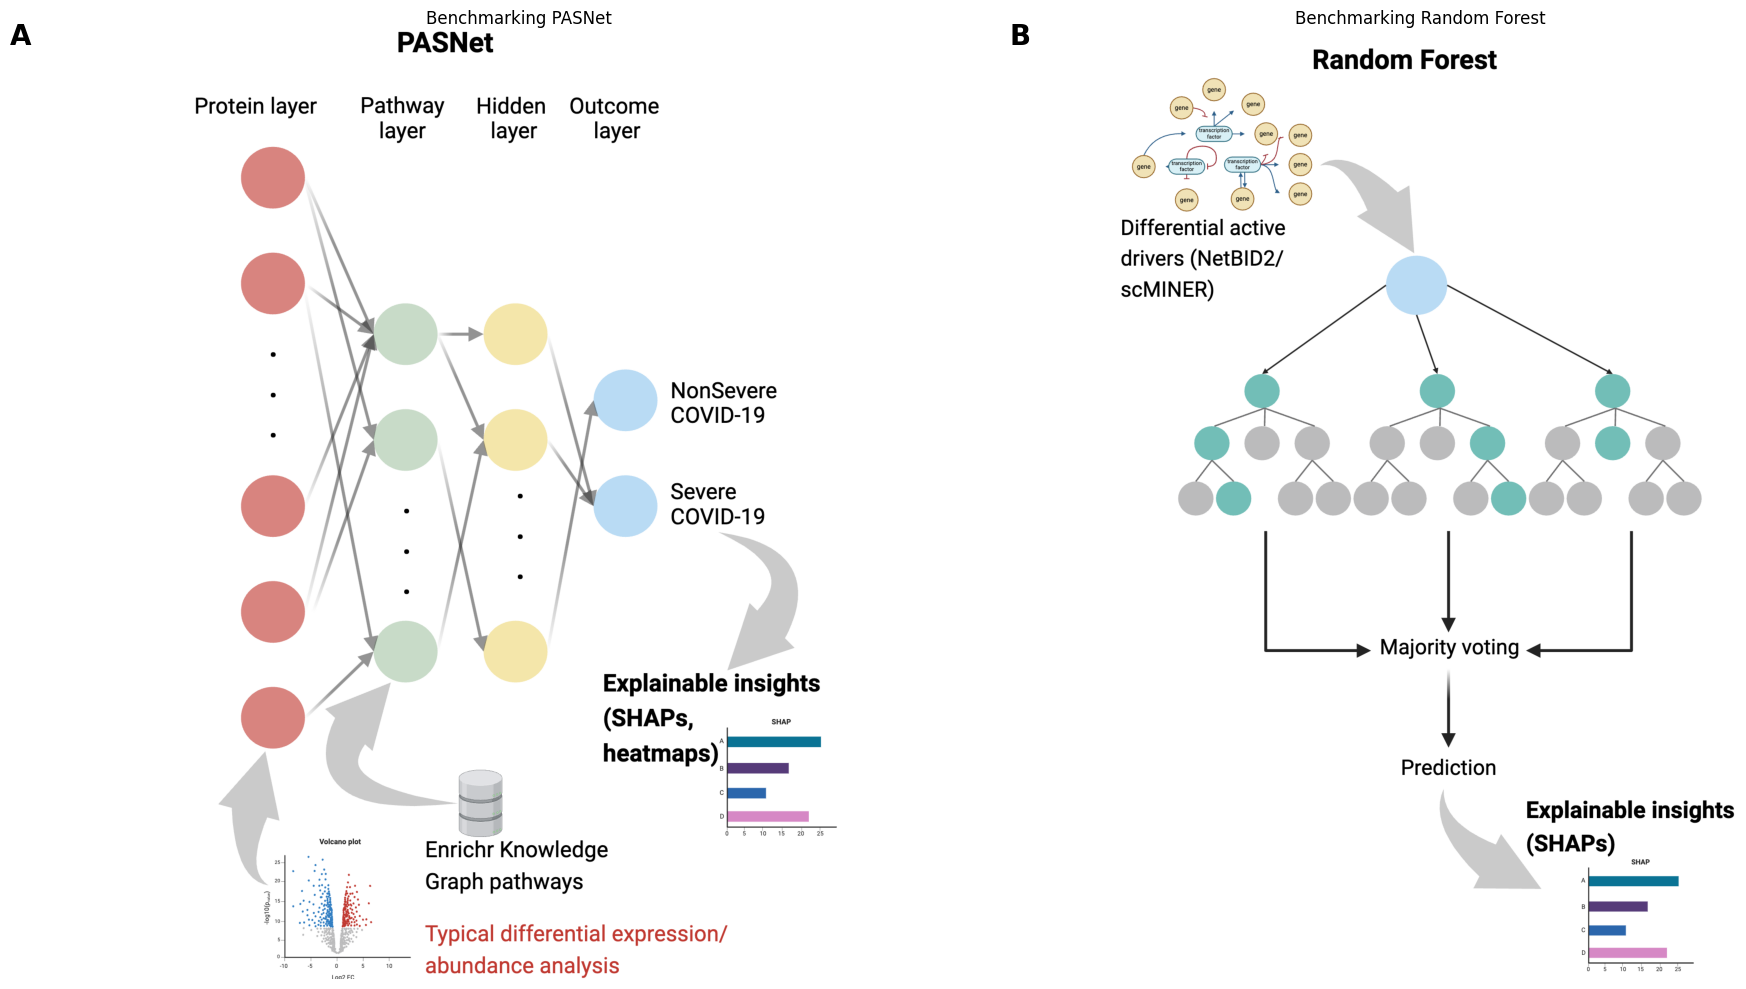

In [ ]:
# Create the figure and axes
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

# Display the first image
axs[0].imshow(img1)
axs[0].axis('off')
axs[0].set_title('Benchmarking PASNet')

# Display the second image
axs[1].imshow(img2)
axs[1].axis('off')
axs[1].set_title('Benchmarking Random Forest')

# Add labels A and B
fig.text(0.02, 0.95, 'A', size=20, weight='bold', ha='left')
fig.text(0.52, 0.95, 'B', size=20, weight='bold', ha='left')

plt.tight_layout()
plt.savefig('Benchmark_images.png', format='png', dpi=300)
plt.show()

## AUC scores

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Load data
dc_mayo_ex = pd.read_csv('Benchmarking_studies/PASNet_Expression_Benchmark/MGH_Mayo_Benchmark/Deep_Learning_Inputs/MAYO_TEST.csv', sep=',')
fl_mayo_ex = pd.read_csv('Benchmarking_studies/PASNet_Expression_Benchmark/MGH_Mayo_Benchmark/Deep_Learning_Outputs/PASNet_pred_0_0.txt', sep=',', names=['first', 'second'])

dc_stanford_ex = pd.read_csv('Benchmarking_studies/PASNet_Expression_Benchmark/MGH_Stanford_Benchmark/Deep_Learning_Inputs/STANFORD_TEST.csv', sep=',')
fl_stanford_ex = pd.read_csv('Benchmarking_studies/PASNet_Expression_Benchmark/MGH_Stanford_Benchmark/Deep_Learning_Outputs/PASNet_pred_0_0.txt', sep=',', names=['first', 'second'])

# Combine predictions
fl_mayo_ex['combined'] = fl_mayo_ex.values.tolist()
fl_stanford_ex['combined'] = fl_stanford_ex.values.tolist()

y_pred_mayo_ex = np.array(list(fl_mayo_ex.combined))
y_pred_stanford_ex = np.array(list(fl_stanford_ex.combined))

def vectorized_label(target, n_class):
    TARGET = np.array(target).reshape(-1)
    return np.eye(n_class)[TARGET]

y_mayo_ex = dc_mayo_ex['Condition'].astype(int)
y_true_mayo_ex = vectorized_label(y_mayo_ex, 2)

y_stanford_ex = dc_stanford_ex['Condition'].astype(int)
y_true_stanford_ex = vectorized_label(y_stanford_ex, 2)

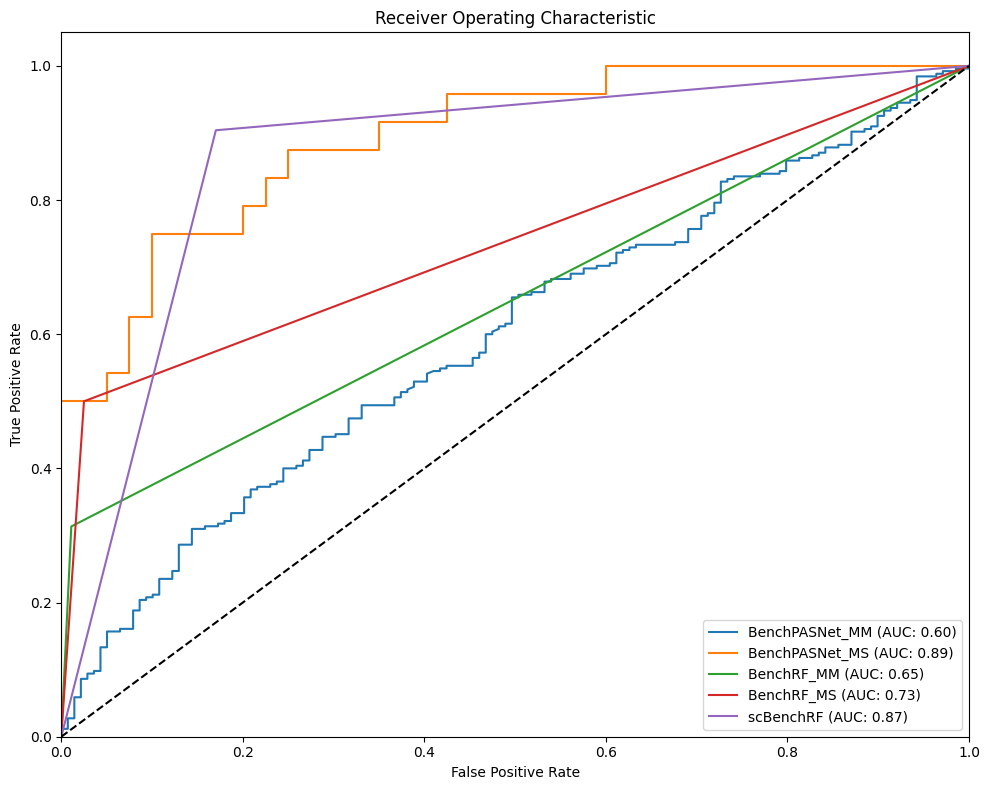

In [ ]:
# Ensure lengths match for each experiment
experiments = [
    ('BenchPASNet_MM (AUC: {:.2f})', y_true_mayo_ex, y_pred_mayo_ex),
    ('BenchPASNet_MS (AUC: {:.2f})', y_true_stanford_ex, y_pred_stanford_ex)
]

# Create the figure and axes
fig, ax = plt.subplots(figsize=(10, 8))

# Plot AUC curves
for label, y_true, y_pred in experiments:
    if y_true.shape[0] != y_pred.shape[0]:
        min_length = min(y_true.shape[0], y_pred.shape[0])
        y_true = y_true[:min_length]
        y_pred = y_pred[:min_length]

    fpr, tpr, _ = roc_curve(y_true[:, 1], y_pred[:, 1])
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, label=label.format(roc_auc))

# Add Random Forest ROC curves
# These values are calculated in Random_Forest_Olink_data and Random_Forest_MGH_scMGH Colab while the PASNet neural network is running on activity values
rf_curves = [
    ('BenchRF_MM (AUC: 0.65)', [0,0.01104972,1], [0,0.31343284,1]),
    ('BenchRF_MS (AUC: 0.73)', [0,0.025,1], [0,0.5,1]),
    ('scBenchRF (AUC: 0.87)', [0,0.17029549,1], [0,0.90401052,1])
]

for label, fpr, tpr in rf_curves:
    ax.plot(fpr, tpr, label=label)

# Plot settings for AUC
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver Operating Characteristic')
ax.legend(loc="lower right")

plt.tight_layout()
plt.savefig('Benchmark_AUC_Curves.png', format='png', dpi=300)
plt.show()

## F1 scores

In [ ]:
# Data for F1 scores
data = {
    'Method': ['BenchPASNet_MM', 'BenchPASNet_MS', 'BenchRF_MM', 'BenchRF_MS', 'scBenchRF'],
    'F1_score': [0.7475, 0.5454, 0.4746, 0.6486, 0.7291] # These values can be found in the ++++
}

df = pd.DataFrame(data)
df = df.sort_values(by='F1_score', ascending=False)

# Define colors matching the AUC plot
colors = {
    'BenchPASNet_MM': 'blue',
    'BenchPASNet_MS': 'green',
    'BenchRF_MM': 'orange',
    'BenchRF_MS': 'red',
    'scBenchRF': 'purple'
}

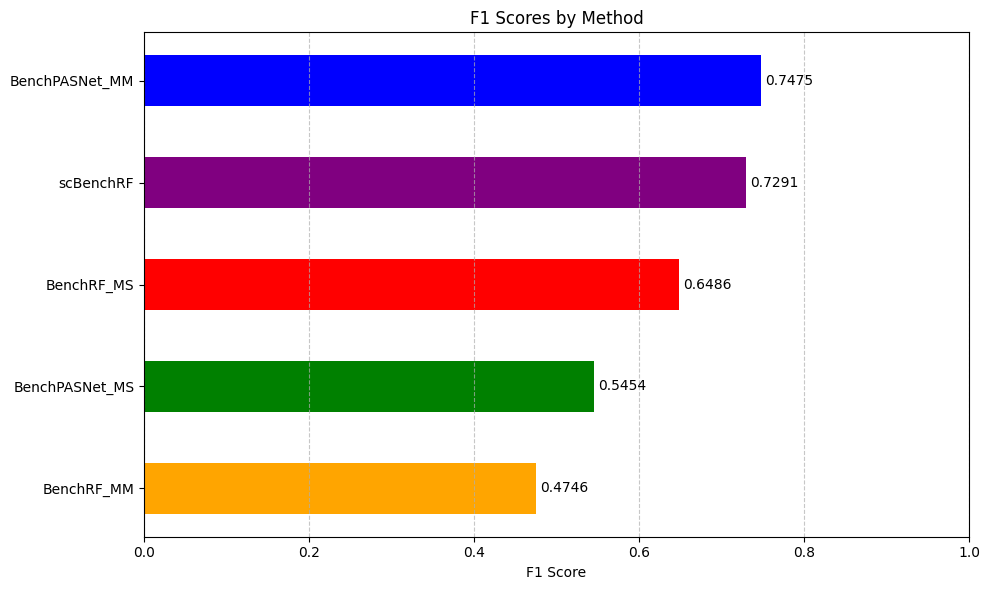

In [ ]:
# Create the bar plot
fig, ax = plt.subplots(figsize=(10, 6))

bars = ax.barh(df['Method'], df['F1_score'], color=[colors[method] for method in df['Method']], height=0.5)
ax.set_xlabel('F1 Score')
ax.set_title('F1 Scores by Method')
ax.set_xlim(0, 1)
ax.grid(axis='x', linestyle='--', alpha=0.7)
ax.invert_yaxis()  # Highest F1 score on top

# Add text labels
for bar in bars:
    width = bar.get_width()
    ax.annotate(f'{width:.4f}', xy=(width, bar.get_y() + bar.get_height() / 2),
                xytext=(3, 0),  # 3 points horizontal offset
                textcoords="offset points",
                ha='left', va='center')

plt.tight_layout()
plt.savefig('Benchmark_F1_Scores.png', format='png', dpi=300)
plt.show()

## SHAP values

In [ ]:
# Load the images
image3_path = 'Benchmarking_studies/PASNet_Expression_Benchmark/MGH_Mayo_Benchmark/Deep_Learning_Outputs/shap_values20.png'
image4_path = 'Benchmarking_studies/PASNet_Expression_Benchmark/MGH_Stanford_Benchmark/Deep_Learning_Outputs/shap_values20.png'
image5_path = 'Benchmarking_studies/RF_activity/shap_values20_Mayo.png'
image6_path = 'Benchmarking_studies/RF_activity/shap_values20_Stanford.png'
image7_path = 'Benchmarking_studies/RF_activity/scMGH/shap_values20_scRF.png'

img3 = mpimg.imread(image3_path)
img4 = mpimg.imread(image4_path)
img5 = mpimg.imread(image5_path)
img6 = mpimg.imread(image6_path)
img7 = mpimg.imread(image7_path)

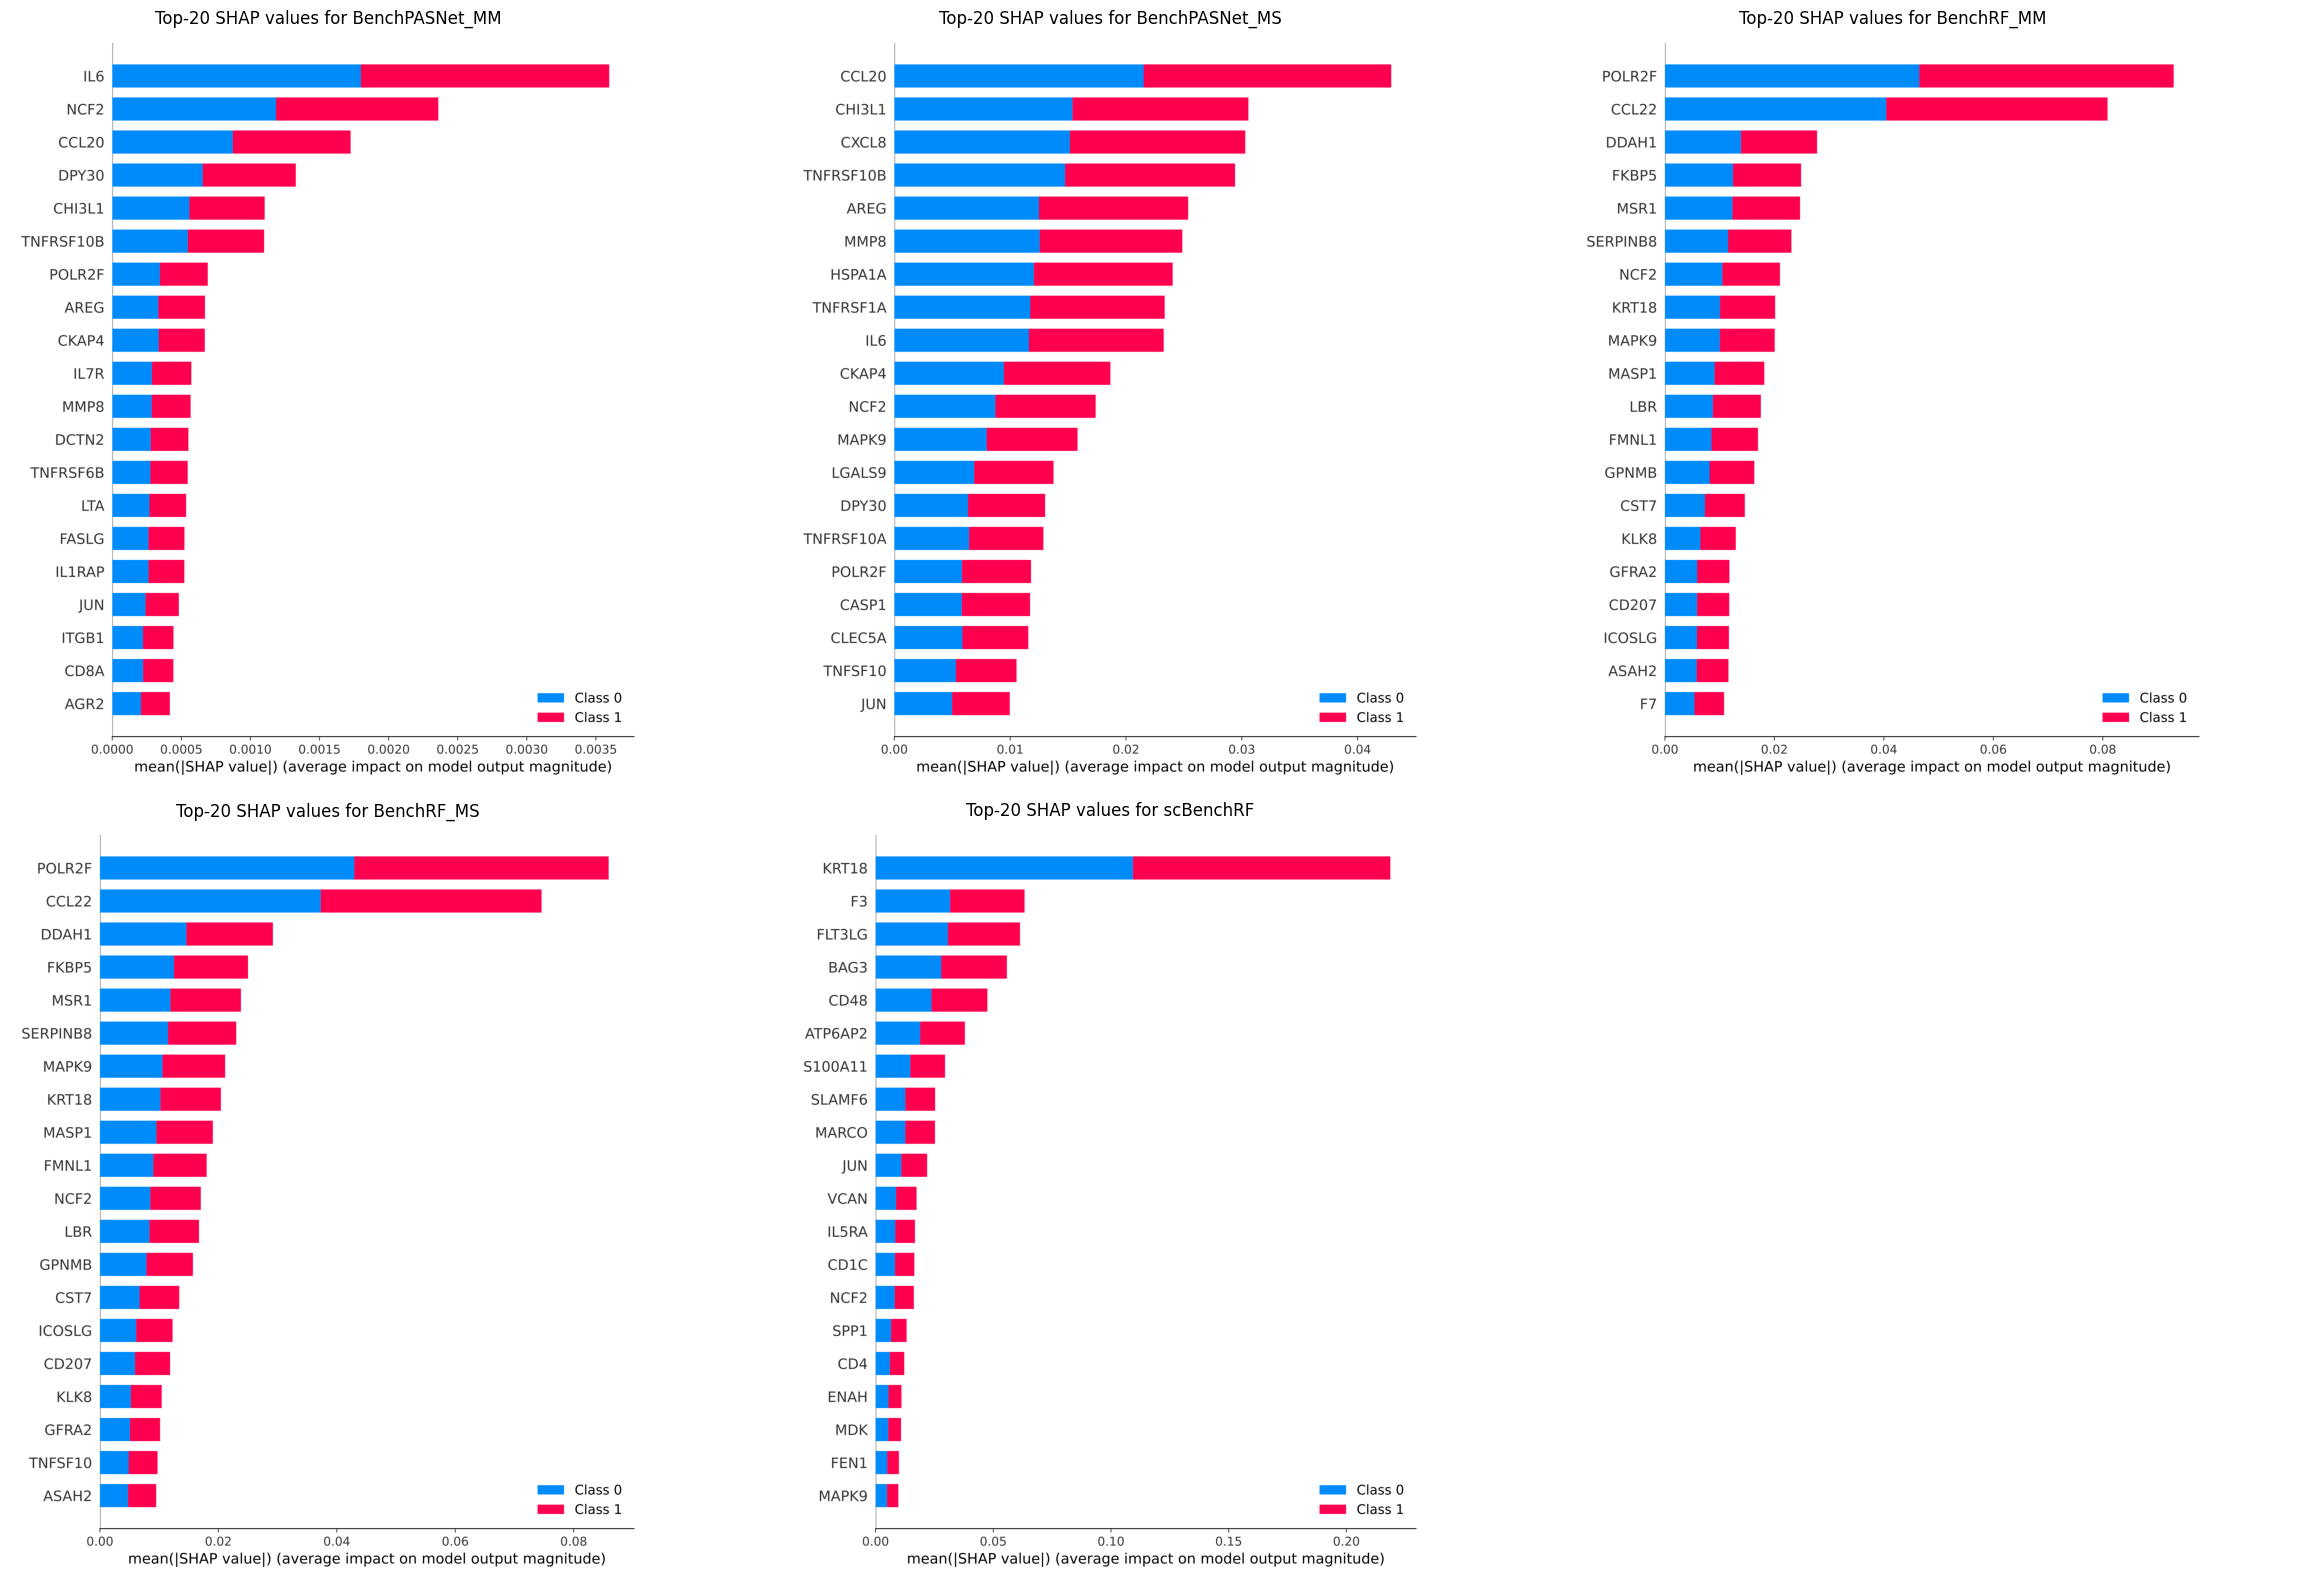

In [ ]:
# Create the figure and axes
fig, axs = plt.subplots(2, 3, figsize=(24, 16))

# Display the images with titles
axs[0, 0].imshow(img3)
axs[0, 0].axis('off')
axs[0, 0].set_title('Top-20 SHAP values for BenchPASNet_MM')

axs[0, 1].imshow(img4)
axs[0, 1].axis('off')
axs[0, 1].set_title('Top-20 SHAP values for BenchPASNet_MS')

axs[0, 2].imshow(img5)
axs[0, 2].axis('off')
axs[0, 2].set_title('Top-20 SHAP values for BenchRF_MM')

axs[1, 0].imshow(img6)
axs[1, 0].axis('off')
axs[1, 0].set_title('Top-20 SHAP values for BenchRF_MS')

axs[1, 1].imshow(img7)
axs[1, 1].axis('off')
axs[1, 1].set_title('Top-20 SHAP values for scBenchRF')

# Make the last subplot invisible
axs[1, 2].axis('off')

plt.tight_layout()
plt.savefig('Benchmark_SHAP_Values.png', format='png', dpi=300)
plt.show()

## Multipanel

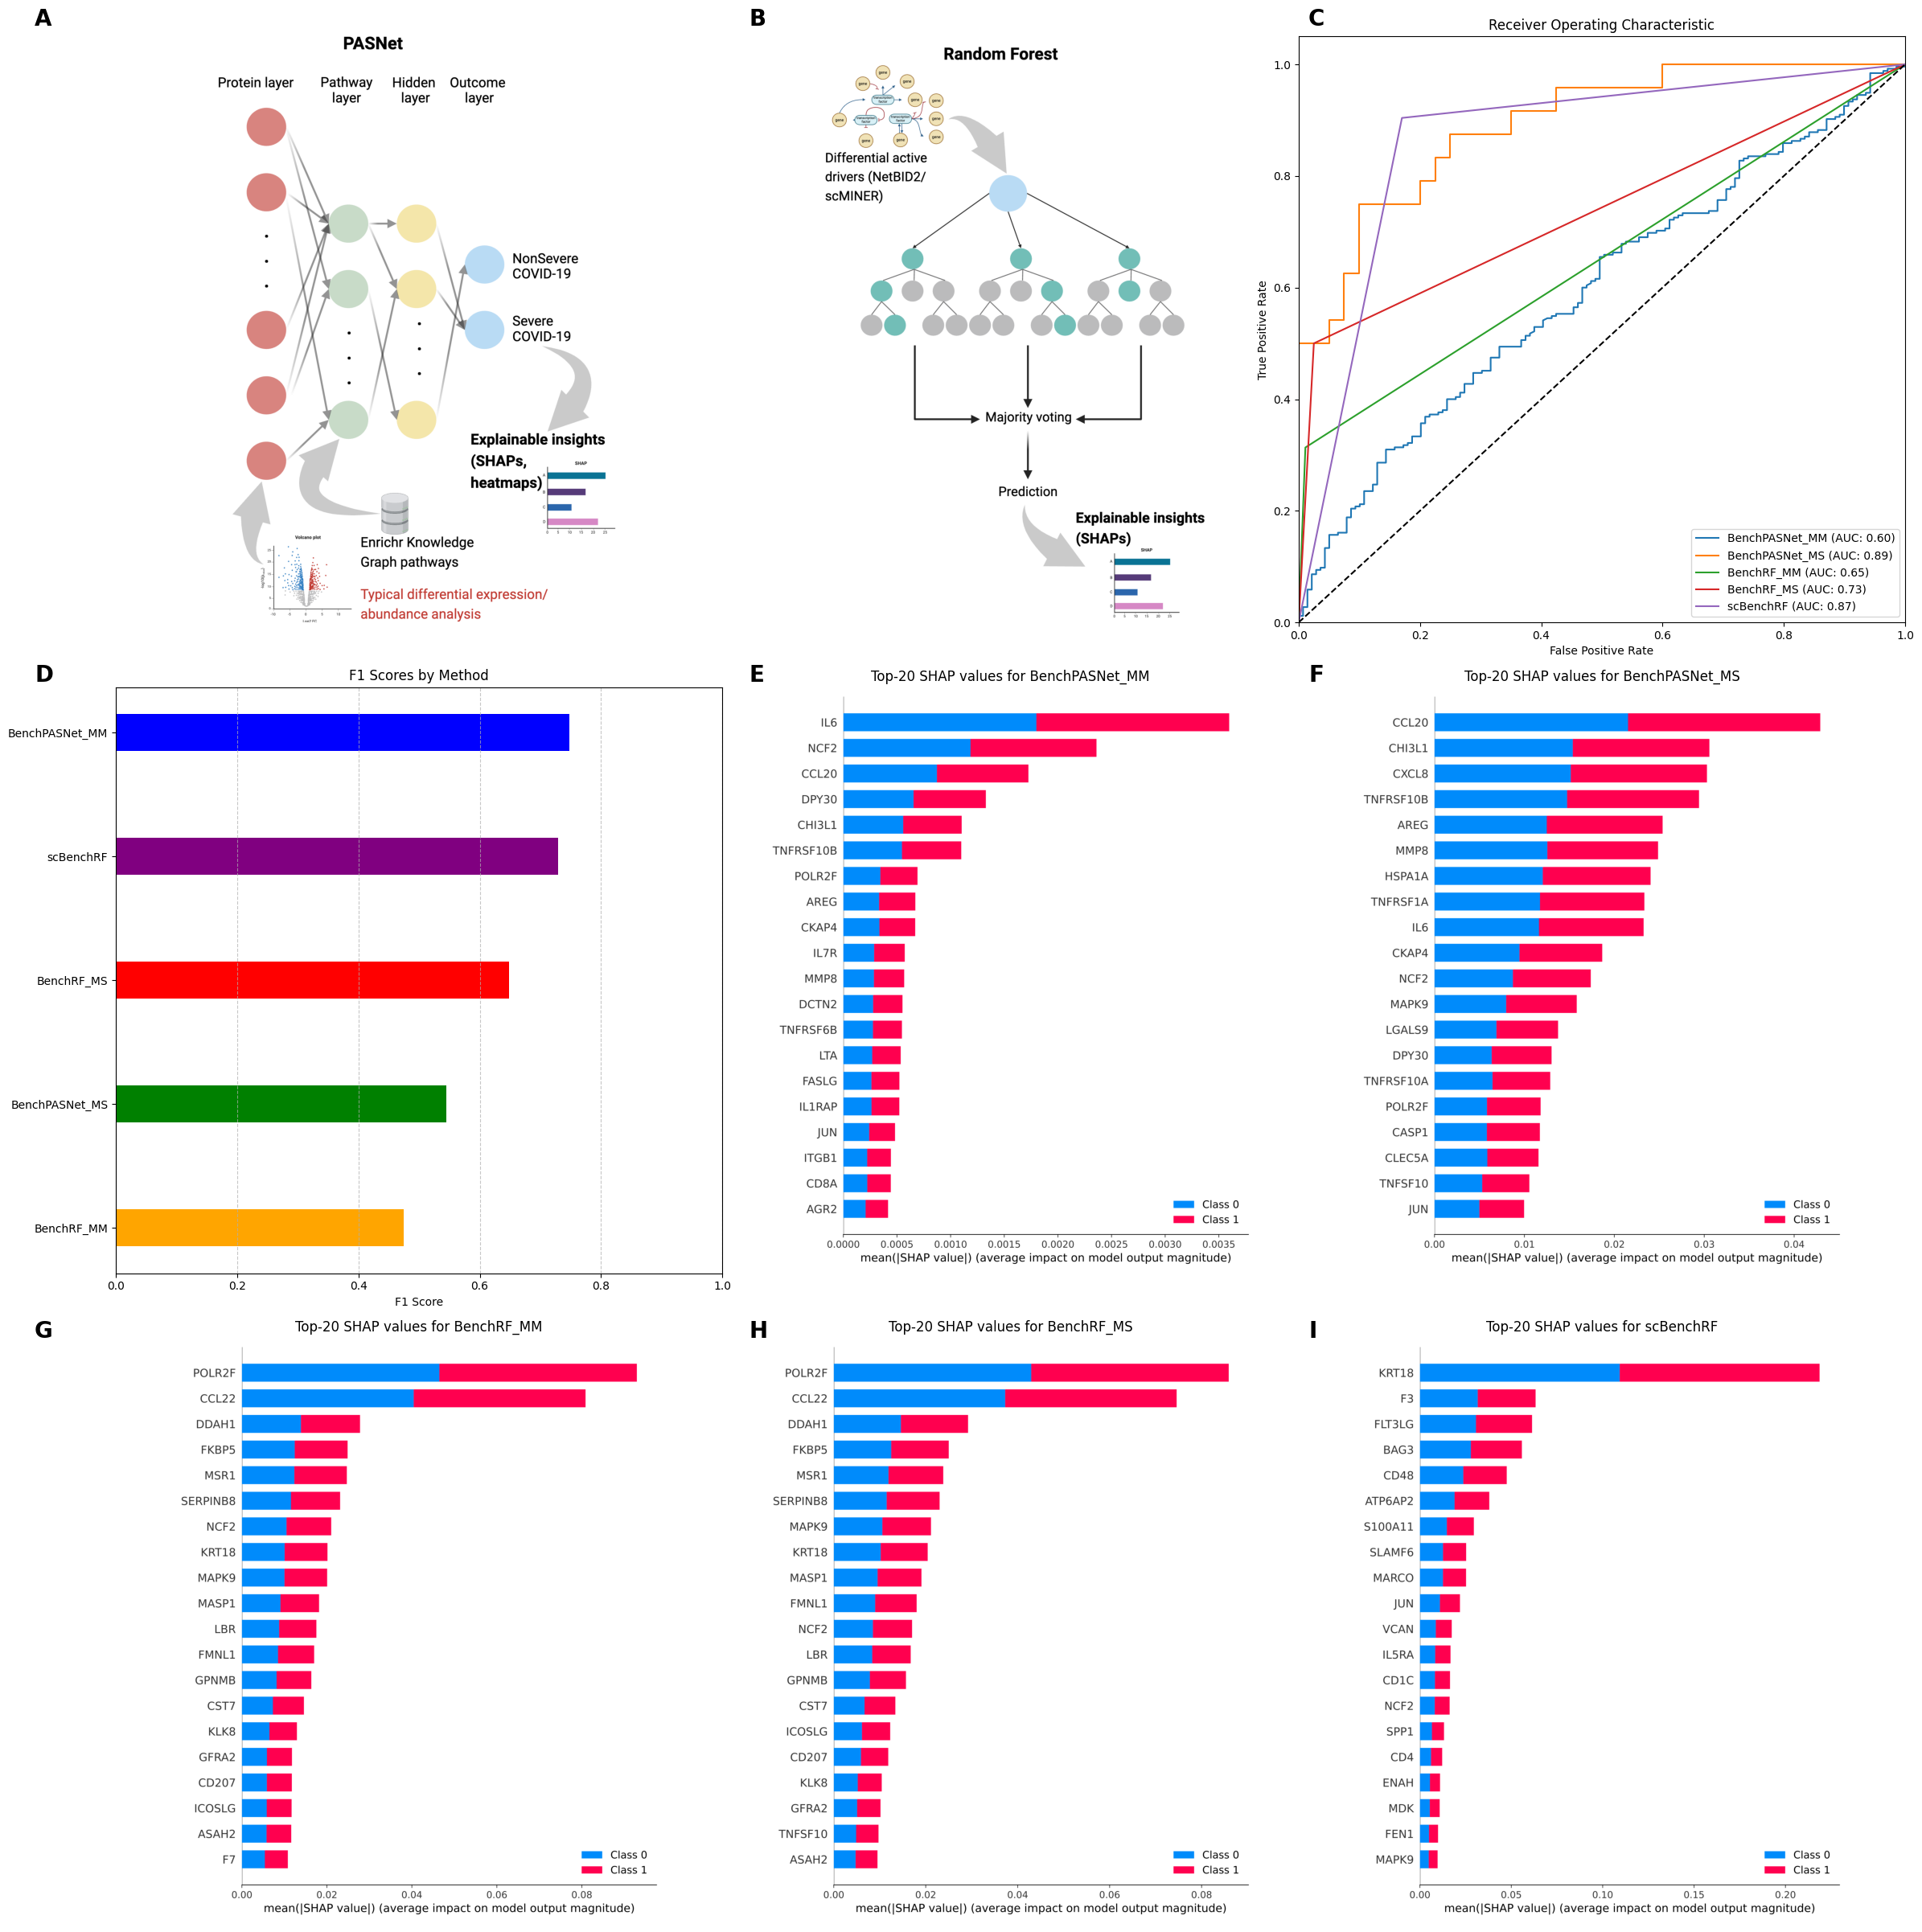

In [ ]:
# Load data
dc_mayo_ex = pd.read_csv('Benchmarking_studies/PASNet_Expression_Benchmark/MGH_Mayo_Benchmark/Deep_Learning_Inputs/MAYO_TEST.csv', sep=',')
fl_mayo_ex = pd.read_csv('Benchmarking_studies/PASNet_Expression_Benchmark/MGH_Mayo_Benchmark/Deep_Learning_Outputs/PASNet_pred_0_0.txt', sep=',', names=['first', 'second'])

dc_stanford_ex = pd.read_csv('Benchmarking_studies/PASNet_Expression_Benchmark/MGH_Stanford_Benchmark/Deep_Learning_Inputs/STANFORD_TEST.csv', sep=',')
fl_stanford_ex = pd.read_csv('Benchmarking_studies/PASNet_Expression_Benchmark/MGH_Stanford_Benchmark/Deep_Learning_Outputs/PASNet_pred_0_0.txt', sep=',', names=['first', 'second'])

# Combine predictions
fl_mayo_ex['combined'] = fl_mayo_ex.values.tolist()
fl_stanford_ex['combined'] = fl_stanford_ex.values.tolist()

y_pred_mayo_ex = np.array(list(fl_mayo_ex.combined))
y_pred_stanford_ex = np.array(list(fl_stanford_ex.combined))

def vectorized_label(target, n_class):
    TARGET = np.array(target).reshape(-1)
    return np.eye(n_class)[TARGET]

y_mayo_ex = dc_mayo_ex['Condition'].astype(int)
y_true_mayo_ex = vectorized_label(y_mayo_ex, 2)

y_stanford_ex = dc_stanford_ex['Condition'].astype(int)
y_true_stanford_ex = vectorized_label(y_stanford_ex, 2)

# Ensure lengths match for each experiment
experiments = [
    ('BenchPASNet_MM (AUC: {:.2f})', y_true_mayo_ex, y_pred_mayo_ex),
    ('BenchPASNet_MS (AUC: {:.2f})', y_true_stanford_ex, y_pred_stanford_ex)
]

# Data for F1 scores
data = {
    'Method': ['BenchPASNet_MM', 'BenchPASNet_MS', 'BenchRF_MM', 'BenchRF_MS', 'scBenchRF'],
    'F1_score': [0.7475, 0.5454, 0.4746, 0.6486, 0.7291]
}

df = pd.DataFrame(data)
df = df.sort_values(by='F1_score', ascending=False)

# Define colors matching the AUC plot
colors = {
    'BenchPASNet_MM': 'blue',
    'BenchPASNet_MS': 'green',
    'BenchRF_MM': 'orange',
    'BenchRF_MS': 'red',
    'scBenchRF': 'purple'
}

# Load the images
image1_path = 'Bench_Pasnet.png'
image2_path = 'RF.png'
image3_path = 'Benchmarking_studies/PASNet_Expression_Benchmark/MGH_Mayo_Benchmark/Deep_Learning_Outputs/shap_values20.png'
image4_path = 'Benchmarking_studies/PASNet_Expression_Benchmark/MGH_Stanford_Benchmark/Deep_Learning_Outputs/shap_values20.png'
image5_path = 'Benchmarking_studies/RF_activity/shap_values20_Mayo.png'
image6_path = 'Benchmarking_studies/RF_activity/shap_values20_Stanford.png'
image7_path = 'Benchmarking_studies/RF_activity/scMGH/shap_values20_scRF.png'

img1 = mpimg.imread(image1_path)
img2 = mpimg.imread(image2_path)
img3 = mpimg.imread(image3_path)
img4 = mpimg.imread(image4_path)
img5 = mpimg.imread(image5_path)
img6 = mpimg.imread(image6_path)
img7 = mpimg.imread(image7_path)

# Create the figure and axes
fig, axs = plt.subplots(3, 3, figsize=(24, 24), gridspec_kw={'width_ratios': [1, 1, 1]})

# Display the first image
axs[0, 0].imshow(img1)
axs[0, 0].axis('off')

# Display the second image
axs[0, 1].imshow(img2)
axs[0, 1].axis('off')

# Plot AUC curves
for label, y_true, y_pred in experiments:
    if y_true.shape[0] != y_pred.shape[0]:
        min_length = min(y_true.shape[0], y_pred.shape[0])
        y_true = y_true[:min_length]
        y_pred = y_pred[:min_length]

    fpr, tpr, _ = roc_curve(y_true[:, 1], y_pred[:, 1])
    roc_auc = auc(fpr, tpr)
    axs[0, 2].plot(fpr, tpr, label=label.format(roc_auc))

# Add Random Forest ROC curves
rf_curves = [
    ('BenchRF_MM (AUC: 0.65)', [0,0.01104972,1], [0,0.31343284,1]),
    ('BenchRF_MS (AUC: 0.73)', [0,0.025,1], [0,0.5,1]),
    ('scBenchRF (AUC: 0.87)', [0,0.17029549,1], [0,0.90401052,1])
]

for label, fpr, tpr in rf_curves:
    axs[0, 2].plot(fpr, tpr, label=label)

# Plot settings for AUC
axs[0, 2].plot([0, 1], [0, 1], 'k--')
axs[0, 2].set_xlim([0.0, 1.0])
axs[0, 2].set_ylim([0.0, 1.05])
axs[0, 2].set_xlabel('False Positive Rate')
axs[0, 2].set_ylabel('True Positive Rate')
axs[0, 2].set_title('Receiver Operating Characteristic')
axs[0, 2].legend(loc="lower right")

# Horizontal Bar Plot for F1 Scores
axs[1, 0].barh(df['Method'], df['F1_score'], color=[colors[method] for method in df['Method']], height=0.3)
axs[1, 0].set_xlabel('F1 Score')
axs[1, 0].set_title('F1 Scores by Method')
axs[1, 0].set_xlim(0, 1)
axs[1, 0].grid(axis='x', linestyle='--', alpha=0.7)
axs[1, 0].invert_yaxis()  # Highest F1 score on top

# Display the third image
axs[1, 1].imshow(img3)
axs[1, 1].axis('off')
axs[1, 1].set_title('Top-20 SHAP values for BenchPASNet_MM')

# Display the fourth image
axs[1, 2].imshow(img4)
axs[1, 2].axis('off')
axs[1, 2].set_title('Top-20 SHAP values for BenchPASNet_MS')

# Display the fifth image
axs[2, 0].imshow(img5)
axs[2, 0].axis('off')
axs[2, 0].set_title('Top-20 SHAP values for BenchRF_MM')

# Display the sixth image
axs[2, 1].imshow(img6)
axs[2, 1].axis('off')
axs[2, 1].set_title('Top-20 SHAP values for BenchRF_MS')

# Display the seventh image
axs[2, 2].imshow(img7)
axs[2, 2].axis('off')
axs[2, 2].set_title('Top-20 SHAP values for scBenchRF')

# Add labels A-I
fig.text(0.02, 0.99, 'A', size=20, weight='bold', ha='left')
fig.text(0.39, 0.99, 'B', size=20, weight='bold', ha='left')
fig.text(0.68, 0.99, 'C', size=20, weight='bold', ha='left')
fig.text(0.02, 0.65, 'D', size=20, weight='bold', ha='left')
fig.text(0.39, 0.65, 'E', size=20, weight='bold', ha='left')
fig.text(0.68, 0.65, 'F', size=20, weight='bold', ha='left')
fig.text(0.02, 0.31, 'G', size=20, weight='bold', ha='left')
fig.text(0.39, 0.31, 'H', size=20, weight='bold', ha='left')
fig.text(0.68, 0.31, 'I', size=20, weight='bold', ha='left')

plt.tight_layout()
plt.savefig('Benchmark_neural_network_outputs_vol3.png', format='png', dpi=300)
plt.show()